## UNSEEN via seasonal mean relationships ##

Trying something slightly different. On a seasonal (e.g. ONDJFM) mean timescale, there are likely to be fairly strong relationships between wind speed and wind power generation, temperature and demand, and irradiance and solar power generation. It therefore stands to reason that a combination of these variables, used with a multi linear regression, could project onto the seasonal mean demand net wind (or demand net renewables). Where we have an observed (hopefully linear) relationship between the surface variables and demand net wind (or demand net renewables), we can extrapolate this so that "worse" (i.e. lower wind speeds, colder temperatures, more dull conditions) conditions produced by DePreSys can map onto worse impacts for demand net wind (or demand net renewables). 

Steps for this:

1. Load in the CLEARHEADS dataset and process into demand net wind (+ demand net renewables), along with the surface variables for the different countries (maybe just UK first).
2. Create scatter plots of the relationship between seasonal mean variables (e.g. 10m wind speed/100m wind speed) and the energy system variable (e.g. wind power generation).
3. Create scatter plots for how the individual seasonal mean variables map onto demand net wind/demand net renewables.
4. Create a multi linear regression for mapping the combination of individual surface variables onto demand net wind/demand net renewables.

In [1]:
# Import local modules
import os
import sys
import glob
import time

# Import third-party modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Specific imports
from tqdm import tqdm

In [2]:
# Import local modules
sys.path.append(os.path.join("/home/users/benhutch/unseen_functions/"))
import functions as funcs

# Import the specific functions written for this processing
import functions_regr as funcs_regr

In [3]:
# Set up the determinant variables
country_code = "UK"
season = "ONDJFM"
start_year = 1979
end_year = 2018

# create the df
df = funcs_regr.create_dnw_df(
    country_code=country_code,
    season=season,
    start_year=start_year,
    end_year=end_year,
)

Country name: United_Kingdom
File UK_CLEARHEADS_S2S4E_1979-01-01_2018-12-31_2024-09-18.csv already exists.
Loading file UK_CLEARHEADS_S2S4E_1979-01-01_2018-12-31_2024-09-18.csv.
  time_in_hours_from_first_jan_1950  10m_wind_speed   ofs_cfs   ons_cfs  \
0                        1979-01-01        4.590929  0.468063  0.242286   
1                        1979-01-02        4.516651  0.637265  0.265492   
2                        1979-01-03        5.599206  0.434049  0.363244   
3                        1979-01-04        5.738192  0.748136  0.270615   
4                        1979-01-05        4.994901  0.420400  0.262179   

   t2m_0_dt  t2m_2020_dt  United_Kingdom_wd_demand  
0 -4.111723    -3.252384                 50.640896  
1 -0.858444     0.000838                 47.996807  
2 -0.305985     0.553239                 47.691554  
3 -0.771951     0.087217                 47.716700  
4 -2.424707    -1.565598                 49.088719  
['1979-01-01' '1979-01-02' '1979-01-03' ... '2018-12-

In [4]:
# print the head of the df
df.head()

,10m_wind_speed,ofs_cfs,ons_cfs,t2m_0_dt,t2m_2020_dt,United_Kingdom_wd_demand,wind_gen_UK,wd_demand_net_wind
time_in_hours_from_first_jan_1950,,,,,,,,
1979,5.261701,0.533410,0.308875,5.501963,6.340399,42.641933,12.462728,30.179205
1980,6.157620,0.657496,0.423716,5.564592,6.382039,42.542308,16.000972,26.541336
1981,5.653434,0.578058,0.366700,4.774112,5.570613,43.249148,13.981184,29.267964
1982,6.218188,0.632823,0.431394,5.859454,6.635009,42.388595,15.751030,26.637564
1983,5.813702,0.571118,0.372322,5.702872,6.457466,42.501667,13.962349,28.539318


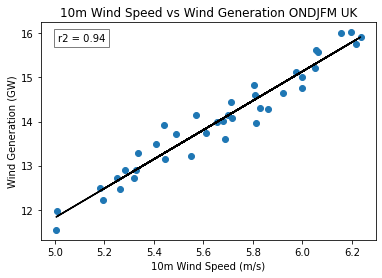

In [5]:
# Use plot_scatter_with_fit to explore
# correlations between 10m wind speed and wind generation
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="10m_wind_speed",
    y_col="wind_gen_UK",
    title="10m Wind Speed vs Wind Generation ONDJFM UK",
    xlabel="10m Wind Speed (m/s)",
    ylabel="Wind Generation (GW)",
)

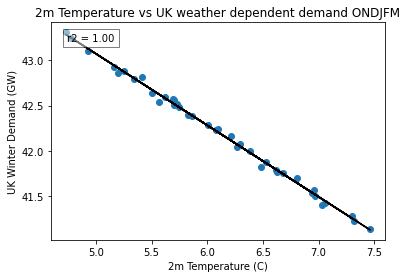

In [6]:
# Use plot_scatter_with_fit to explore
# correlations between t2m_0_dt and United_Kingdom_wd_demand
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="t2m_0_dt",
    y_col="United_Kingdom_wd_demand",
    title="2m Temperature vs UK weather dependent demand ONDJFM",
    xlabel="2m Temperature (C)",
    ylabel="UK Winter Demand (GW)",
)

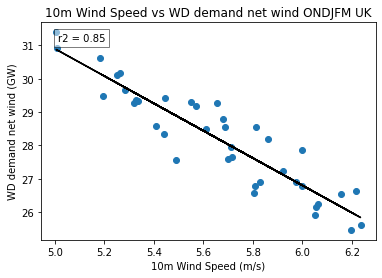

In [7]:
# relationship betqeen 10m wind speed and wd_demand_net_wind
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="10m_wind_speed",
    y_col="wd_demand_net_wind",
    title="10m Wind Speed vs WD demand net wind ONDJFM UK",
    xlabel="10m Wind Speed (m/s)",
    ylabel="WD demand net wind (GW)",
)

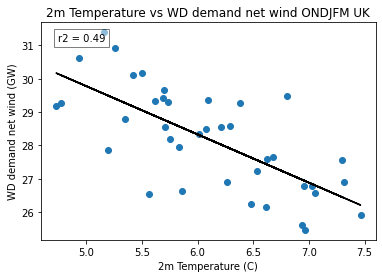

In [8]:
# betqeen t2m_0_dt and wd_demand_net_wind
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="t2m_0_dt",
    y_col="wd_demand_net_wind",
    title="2m Temperature vs WD demand net wind ONDJFM UK",
    xlabel="2m Temperature (C)",
    ylabel="WD demand net wind (GW)",
)

R-squared: 0.97
RMSE: 0.28


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


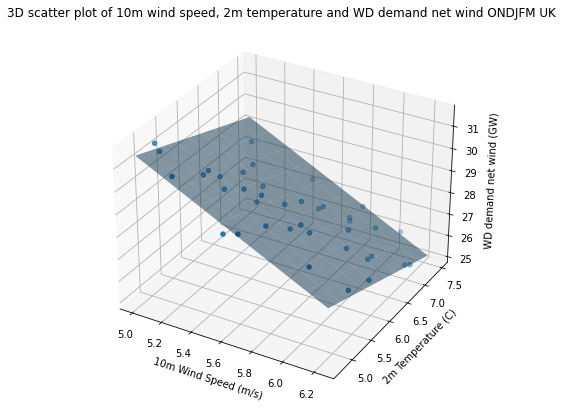

In [9]:
# plot 3d scatter
funcs_regr.plot_3d_scatter(
    df=df,
    x_col="10m_wind_speed",
    y_col="t2m_0_dt",
    z_col="wd_demand_net_wind",
    title="3D scatter plot of 10m wind speed, 2m temperature and WD demand net wind ONDJFM UK",
    xlabel="10m Wind Speed (m/s)",
    ylabel="2m Temperature (C)",
    zlabel="WD demand net wind (GW)",
)

In [10]:
# reload the regression functions
import importlib

importlib.reload(funcs_regr)

<module 'functions_regr' from '/home/users/benhutch/unseen_functions/functions_regr.py'>

R-squared: 0.97
RMSE: 0.28


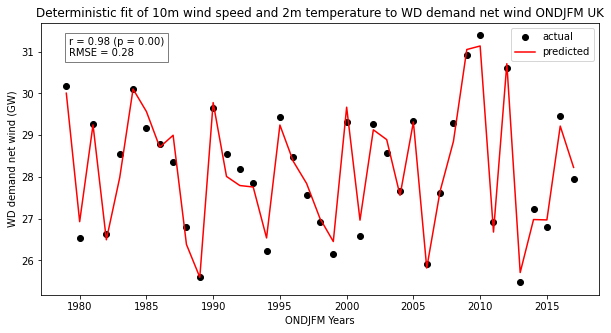

In [11]:
# plot the deterministic fit
funcs_regr.plot_deterministic_fit(
    df=df,
    X1_col="10m_wind_speed",
    X2_col="t2m_0_dt",
    Y_col="wd_demand_net_wind",
    title="Deterministic fit of 10m wind speed and 2m temperature to WD demand net wind ONDJFM UK",
    xlabel="ONDJFM Years",
    ylabel="WD demand net wind (GW)",
)

100%|██████████| 1000/1000 [00:00<00:00, 2351.60it/s]


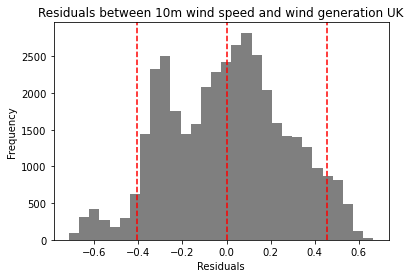

Mean residual spread: 0.27
5th percentile residual spread: 0.23
95th percentile residual spread: 0.31


In [12]:
# Plot the residuals
# between 10m wind speed and wind generation uk
funcs_regr.plot_residual_hist_first(
    df=df,
    x_col="10m_wind_speed",
    y_col="wind_gen_UK",
    title="Residuals between 10m wind speed and wind generation UK",
    xlabel="Residuals",
    ylabel="Frequency",
)

100%|██████████| 1000/1000 [00:00<00:00, 2320.02it/s]


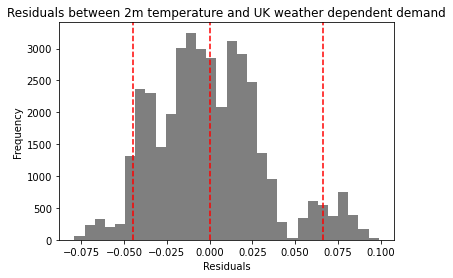

Mean residual spread: 0.03
5th percentile residual spread: 0.02
95th percentile residual spread: 0.04


In [13]:
# plot the residuals between t2m_0_dt and United_Kingdom_wd_demand
funcs_regr.plot_residual_hist_first(
    df=df,
    x_col="t2m_0_dt",
    y_col="United_Kingdom_wd_demand",
    title="Residuals between 2m temperature and UK weather dependent demand",
    xlabel="Residuals",
    ylabel="Frequency",
)

100%|██████████| 1000/1000 [00:01<00:00, 726.96it/s]


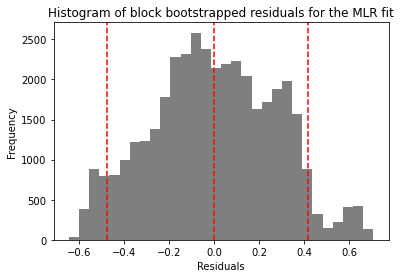

Mean residual spread: 0.27
5th percentile residual spread: 0.23
95th percentile residual spread: 0.32
Mean r2: 0.96
5th percentile r2: 0.94
95th percentile r2: 0.98
Mean RMSE: 0.27
5th percentile RMSE: 0.23
95th percentile RMSE: 0.32


In [14]:
# Plot the histogram of block bootstrapped residuals for the MLR fit
funcs_regr.plot_residual_hist_mlr(
    df=df,
    X1_col="10m_wind_speed",
    X2_col="t2m_0_dt",
    Y_col="wd_demand_net_wind",
    title="Histogram of block bootstrapped residuals for the MLR fit",
    xlabel="Residuals",
    ylabel="Frequency",
    nboot=1000,
)

In [15]:
# reload the regression functions
import importlib

importlib.reload(funcs_regr)

<module 'functions_regr' from '/home/users/benhutch/unseen_functions/functions_regr.py'>

Sampling uncertainty in the MLR fit via stochastic trials.
And sample uncertainty in the time series via block bootstrapping.


  7%|▋         | 66/1000 [00:00<00:01, 653.02it/s]

(39, 2)


 21%|██        | 208/1000 [00:00<00:01, 693.72it/s]

100%|██████████| 1000/1000 [00:01<00:00, 680.94it/s]


Shape of Y_pred_first: (39,)
Shape of stoch_mean: (39, 1000)
Trials mean head:                                          0          1          2          3    \
time_in_hours_from_first_jan_1950                                               
1979                               29.776959  30.351937  29.360800  29.880959   
1980                               26.658053  26.533882  26.926147  26.789840   
1981                               29.687450  29.261921  29.214518  29.254633   
1982                               26.289924  26.410180  26.536354  26.313201   
1983                               27.933487  28.083732  27.977028  28.208913   

                                         4          5          6          7    \
time_in_hours_from_first_jan_1950                                               
1979                               29.538478  30.372637  29.945421  29.671356   
1980                               26.491647  26.891603  26.914887  26.743912   
1981                         

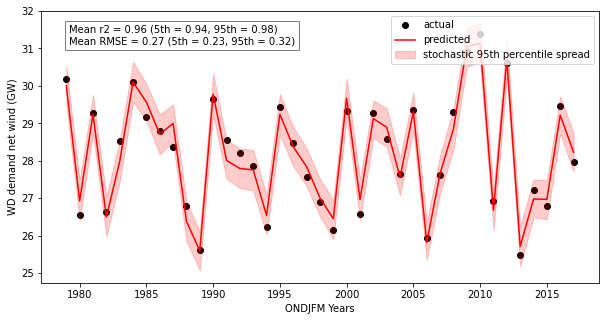

In [16]:
# plot the stochastic fit
funcs_regr.plot_stochastic_fit(
    df=df,
    X1_col="10m_wind_speed",
    X2_col="t2m_0_dt",
    Y_col="wd_demand_net_wind",
    title="Stochastic fit of 10m wind speed and 2m temperature to WD demand net wind ONDJFM UK",
    xlabel="ONDJFM Years",
    ylabel="WD demand net wind (GW)",
    sample_uncertainty=True,
)

In [17]:
# test the new function for loading the observed data
# as processed from the ERA5 monthly (?) data
# regridded to the same resolution as DePreSys
obs_df = funcs_regr.load_processed_obs_data(
    country_name="United Kingdom",
    season="ONDJFM",
    start_year=1960,
    end_year=2018,
)

             sfcWind         tas
time                            
1960-10-01  4.131944  282.668868
1960-11-01  4.934281  279.559365
1960-12-01  4.428460  276.477476
1961-01-01  4.940405  275.904981
1961-02-01  5.247938  279.151625
             sfcWind         tas
time                            
1961-12-31  4.943203  277.546575
1962-12-31  4.461803  275.847431
1963-12-31  4.545248  277.939379
1964-12-31  4.559657  277.520771
1965-12-31  4.866000  277.745086


In [18]:
obs_df.tail()

,sfcWind,tas
time,,
2013,5.544800,6.920070
2014,5.245268,6.415540
2015,5.276976,7.046968
2016,4.572490,6.627535
2017,5.092172,5.715136


In [19]:
df.head()

,10m_wind_speed,ofs_cfs,ons_cfs,t2m_0_dt,t2m_2020_dt,United_Kingdom_wd_demand,wind_gen_UK,wd_demand_net_wind
time_in_hours_from_first_jan_1950,,,,,,,,
1979,5.261701,0.533410,0.308875,5.501963,6.340399,42.641933,12.462728,30.179205
1980,6.157620,0.657496,0.423716,5.564592,6.382039,42.542308,16.000972,26.541336
1981,5.653434,0.578058,0.366700,4.774112,5.570613,43.249148,13.981184,29.267964
1982,6.218188,0.632823,0.431394,5.859454,6.635009,42.388595,15.751030,26.637564
1983,5.813702,0.571118,0.372322,5.702872,6.457466,42.501667,13.962349,28.539318


In [20]:
# subset the obs_df to have the same years as the df
obs_df = obs_df.loc[(obs_df.index >= 1979) & (obs_df.index <= 2018)]

In [21]:
# compute the bias relative to clearheads
sfcWind_bias_ch = obs_df["sfcWind"].mean() - df["10m_wind_speed"].mean()

# compute the bias relative to clearheads
tas_bias_ch = obs_df["tas"].mean() - df["t2m_0_dt"].mean()

# print these
print(f"10m wind speed bias relative to clearheads: {sfcWind_bias_ch:.2f} m/s")

print(f"2m temperature bias relative to clearheads: {tas_bias_ch:.2f} C")

10m wind speed bias relative to clearheads: -0.59 m/s
2m temperature bias relative to clearheads: -0.13 C


In [22]:
# add the columns from the obs_df to the df
df["sfcWind_mon"] = obs_df["sfcWind"]
df["tas_mon"] = obs_df["tas"]

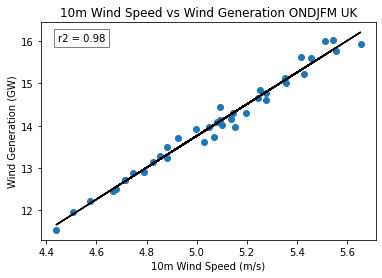

In [23]:
# Repeat the simple plots with the observed data
# e.g., 10m wind speed vs wind generation
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="sfcWind_mon",
    y_col="wind_gen_UK",
    title="10m Wind Speed vs Wind Generation ONDJFM UK",
    xlabel="10m Wind Speed (m/s)",
    ylabel="Wind Generation (GW)",
)

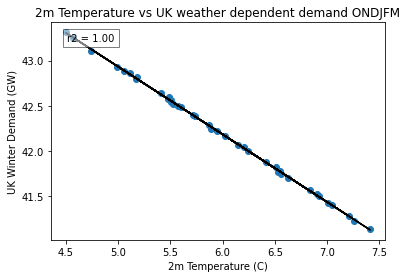

In [24]:
# tas vs United_Kingdom_wd_demand
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="tas_mon",
    y_col="United_Kingdom_wd_demand",
    title="2m Temperature vs UK weather dependent demand ONDJFM",
    xlabel="2m Temperature (C)",
    ylabel="UK Winter Demand (GW)",
)

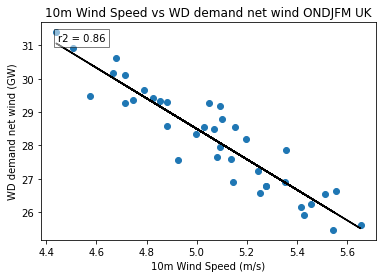

In [25]:
# 10m wind speed and wd_demand_net_wind
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="sfcWind_mon",
    y_col="wd_demand_net_wind",
    title="10m Wind Speed vs WD demand net wind ONDJFM UK",
    xlabel="10m Wind Speed (m/s)",
    ylabel="WD demand net wind (GW)",
)

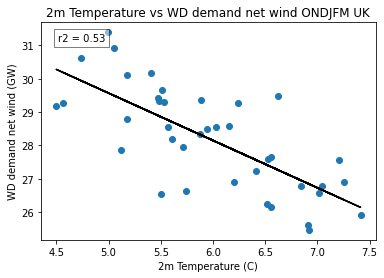

In [26]:
# tas and wd_demand_net_wind
funcs_regr.plot_scatter_with_fit(
    df=df,
    x_col="tas_mon",
    y_col="wd_demand_net_wind",
    title="2m Temperature vs WD demand net wind ONDJFM UK",
    xlabel="2m Temperature (C)",
    ylabel="WD demand net wind (GW)",
)

R-squared: 0.99
RMSE: 0.17


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


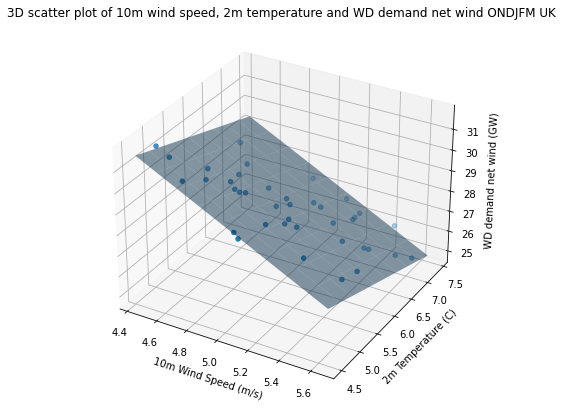

In [27]:
# plot the 3d scatter fit of 10m wind speed, 2m temperature and WD demand net wind
funcs_regr.plot_3d_scatter(
    df=df,
    x_col="sfcWind_mon",
    y_col="tas_mon",
    z_col="wd_demand_net_wind",
    title="3D scatter plot of 10m wind speed, 2m temperature and WD demand net wind ONDJFM UK",
    xlabel="10m Wind Speed (m/s)",
    ylabel="2m Temperature (C)",
    zlabel="WD demand net wind (GW)",
)

R-squared: 0.99
RMSE: 0.17


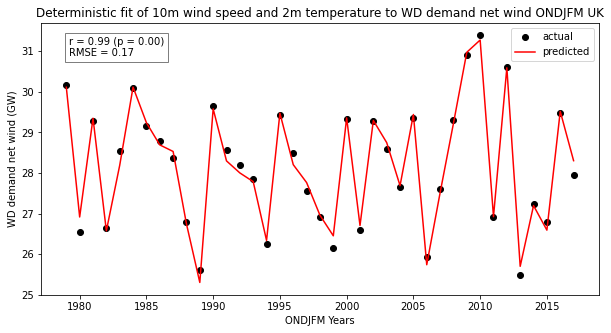

In [28]:
# plot the deterministic fit
funcs_regr.plot_deterministic_fit(
    df=df,
    X1_col="sfcWind_mon",
    X2_col="tas_mon",
    Y_col="wd_demand_net_wind",
    title="Deterministic fit of 10m wind speed and 2m temperature to WD demand net wind ONDJFM UK",
    xlabel="ONDJFM Years",
    ylabel="WD demand net wind (GW)",
)

100%|██████████| 1000/1000 [00:00<00:00, 2251.25it/s]


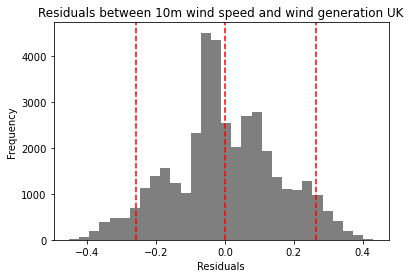

Mean residual spread: 0.15
5th percentile residual spread: 0.13
95th percentile residual spread: 0.18


In [29]:
# plot the residuals between 10m wind speed and wind generation uk
funcs_regr.plot_residual_hist_first(
    df=df,
    x_col="sfcWind_mon",
    y_col="wind_gen_UK",
    title="Residuals between 10m wind speed and wind generation UK",
    xlabel="Residuals",
    ylabel="Frequency",
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2215.25it/s]


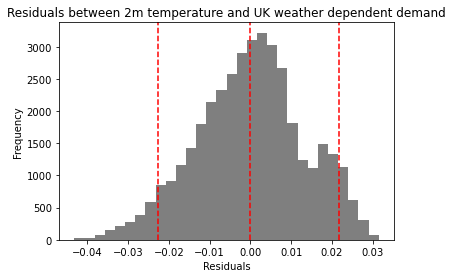

Mean residual spread: 0.01
5th percentile residual spread: 0.01
95th percentile residual spread: 0.01


In [30]:
# plot the residuals between tas and United_Kingdom_wd_demand
funcs_regr.plot_residual_hist_first(
    df=df,
    x_col="tas_mon",
    y_col="United_Kingdom_wd_demand",
    title="Residuals between 2m temperature and UK weather dependent demand",
    xlabel="Residuals",
    ylabel="Frequency",
)

100%|██████████| 1000/1000 [00:01<00:00, 714.42it/s]


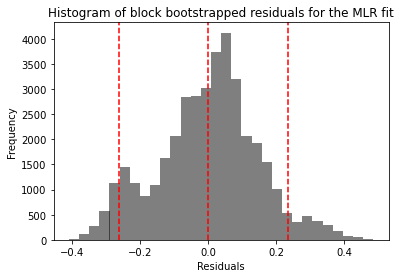

Mean residual spread: 0.15
5th percentile residual spread: 0.12
95th percentile residual spread: 0.17
Mean r2: 0.99
5th percentile r2: 0.98
95th percentile r2: 0.99
Mean RMSE: 0.15
5th percentile RMSE: 0.12
95th percentile RMSE: 0.17


In [31]:
# plot the histogram of block bootstrapped residuals for the MLR fit
funcs_regr.plot_residual_hist_mlr(
    df=df,
    X1_col="sfcWind_mon",
    X2_col="tas_mon",
    Y_col="wd_demand_net_wind",
    title="Histogram of block bootstrapped residuals for the MLR fit",
    xlabel="Residuals",
    ylabel="Frequency",
    nboot=1000,
)

Sampling uncertainty in the MLR fit via stochastic trials.
And sample uncertainty in the time series via block bootstrapping.


  7%|▋         | 72/1000 [00:00<00:01, 717.80it/s]

(39, 2)


100%|██████████| 1000/1000 [00:01<00:00, 742.36it/s]


Shape of Y_pred_first: (39,)
Shape of stoch_mean: (39, 1000)
Trials mean head:                                          0          1          2          3    \
time_in_hours_from_first_jan_1950                                               
1979                               30.471049  30.209641  30.065436  29.908198   
1980                               27.046848  27.057173  27.114928  26.930876   
1981                               29.331732  29.313340  29.586431  29.330213   
1982                               26.477255  26.443621  26.639047  26.619238   
1983                               28.080333  27.946532  28.182533  28.664349   

                                         4          5          6          7    \
time_in_hours_from_first_jan_1950                                               
1979                               30.225091  30.213408  30.064384  30.225136   
1980                               26.920000  26.792093  26.758337  26.954156   
1981                         

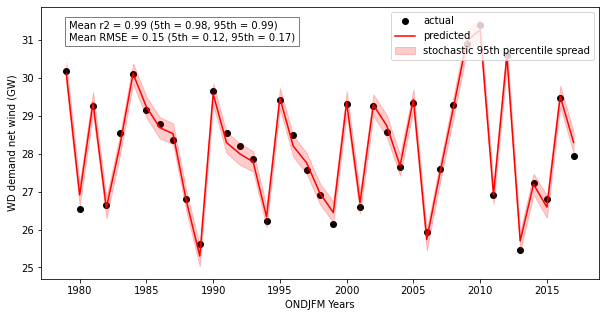

In [32]:
# plot the stochastic fit
# including uncertainty in regression coefficients
# and sample uncertainty
funcs_regr.plot_stochastic_fit(
    df=df,
    X1_col="sfcWind_mon",
    X2_col="tas_mon",
    Y_col="wd_demand_net_wind",
    title="Stochastic fit of 10m wind speed and 2m temperature to WD demand net wind ONDJFM UK",
    xlabel="ONDJFM Years",
    ylabel="WD demand net wind (GW)",
    sample_uncertainty=True,
)

In [33]:
# Load the model data with the new function
# model tas less biased than sfcWind
model_df = funcs_regr.load_processed_model_data(
    obs_df=df,
    country_name="United Kingdom",
    season="ONDJFM",
    start_year=1960,
    end_year=2018,
)

   init_year  member  lead       tas   sfcWind
0       1979      10     1  4.459443  5.087750
0       1979      10     2  5.544535  5.183876
0       1979      10     3  5.881409  5.804815
0       1979      10     4  4.661620  5.391016
0       1979      10     5  4.434789  5.165223
Mean sfcWind bias: 0.07
Mean tas bias: -0.66


In [34]:
df.head()

,10m_wind_speed,ofs_cfs,ons_cfs,t2m_0_dt,t2m_2020_dt,United_Kingdom_wd_demand,wind_gen_UK,wd_demand_net_wind,sfcWind_mon,tas_mon
time_in_hours_from_first_jan_1950,,,,,,,,,,
1979,5.261701,0.533410,0.308875,5.501963,6.340399,42.641933,12.462728,30.179205,4.667155,5.406317
1980,6.157620,0.657496,0.423716,5.564592,6.382039,42.542308,16.000972,26.541336,5.512376,5.501478
1981,5.653434,0.578058,0.366700,4.774112,5.570613,43.249148,13.981184,29.267964,5.049411,4.565228
1982,6.218188,0.632823,0.431394,5.859454,6.635009,42.388595,15.751030,26.637564,5.555151,5.738541
1983,5.813702,0.571118,0.372322,5.702872,6.457466,42.501667,13.962349,28.539318,5.153566,5.568890


In [35]:
# reset the index of df
df = df.reset_index()

# rename time_in_hours_from_first_jan_1950 to time
df = df.rename(columns={"time_in_hours_from_first_jan_1950": "time"})

In [36]:
model_df.tail()

,init_year,member,lead,tas,sfcWind,sfcWind_bc,tas_bc
0,2018,9,6,6.183039,5.204433,5.138304,6.843789
0,2018,9,7,5.353054,4.479786,4.413658,6.013804
0,2018,9,8,6.515549,5.056404,4.990276,7.176299
0,2018,9,9,6.117311,5.847944,5.781816,6.778062
0,2018,9,10,5.283682,4.854574,4.788445,5.944433


In [37]:
df.tail()

,time,10m_wind_speed,ofs_cfs,ons_cfs,t2m_0_dt,t2m_2020_dt,United_Kingdom_wd_demand,wind_gen_UK,wd_demand_net_wind,sfcWind_mon,tas_mon
34,2013,6.195638,0.647097,0.435729,6.965472,7.091237,41.498652,16.026116,25.472536,5.544800,6.920070
35,2014,5.920352,0.593102,0.396775,6.530071,6.634890,41.875410,14.650266,27.225144,5.245268,6.415540
36,2015,5.808130,0.604708,0.382059,7.029012,7.112870,41.399536,14.602774,26.796763,5.276976,7.046968
37,2016,5.195290,0.512427,0.313831,6.802142,6.865010,41.695431,12.226788,29.468643,4.572490,6.627535
38,2017,5.712245,0.604244,0.371476,5.828195,5.870117,42.393328,14.438589,27.954740,5.092172,5.715136


In [38]:
# limit model_df to the same years as df
model_df = model_df.loc[(model_df["init_year"] >= 1979) & (model_df["init_year"] <= 2017)]

In [39]:
# reload the functions
importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [40]:
# assert that the len on model_df["init_year"].unique()
# if equal to the len of df["time"].unique()
assert len(model_df["init_year"].unique()) == len(df["time"].unique())

In [41]:
# len of model_df["init_year"].unique()
len(model_df["init_year"].unique())

39

In [42]:
# reload the functions
importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

-59.84294671414757
0.032932116030094764
2.5%tile slope: 0.021445073394763325
97.5%tile slope: 0.055199012256684915


/home/users/benhutch/unseen_functions/functions.py:3187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_this[f"{model_val_name}_detrended"] = model_data_this[model_val_name] - trend_line


ValueError: cannot reindex on an axis with duplicate labels

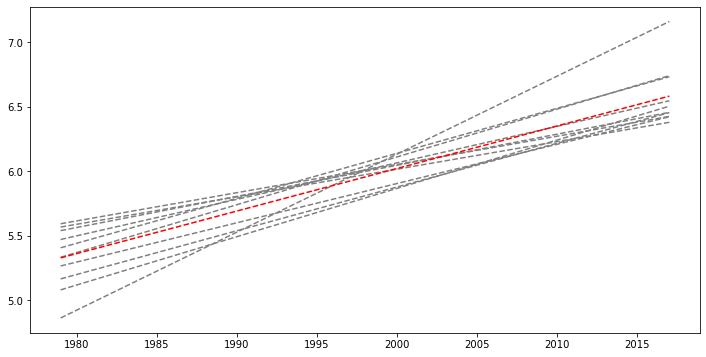

In [43]:
# Same for temperature
funcs.plot_events_ts(
    obs_df=df,
    model_df=model_df,
    obs_val_name='tas_mon',
    model_val_name='tas_bc',
    ylabel='2m temperature (C)',
    obs_time_name='time',
    model_time_name='init_year',
    delta_shift_bias=False,
    figsize=(12, 6),
)

16.90407447804852
-0.005945310659273054
-0.016605114864150405
0.000311870939477788


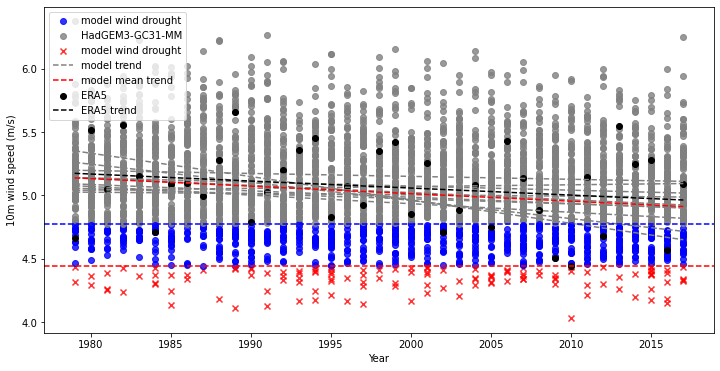

In [77]:
# UNSEEN for the ingredients of demand net wind
# first 10m wind speeds
funcs.plot_events_ts(
    obs_df=df,
    model_df=model_df,
    obs_val_name='sfcWind_mon',
    model_val_name='sfcWind_bc',
    ylabel='10m wind speed (m/s)',
    obs_time_name='time',
    model_time_name='init_year',
    delta_shift_bias=False,
    figsize=(12, 6),
)

In [ ]:
# reload the functions
importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

Need to apply some detrending to the model temperature to remove the externally forced trend. Otherwise we will just end up with more extremes in the earlier half of the period. Particularly for countries very dependent on demand.

100%|██████████| 1000/1000 [00:01<00:00, 776.25it/s]
/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


The shape of X_model is (3900, 2)


/home/users/benhutch/unseen_functions/functions.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f"{Y_col}_pred_err"] = model_data[f"{Y_col}_pred"].values - yerr[
/home/users/benhutch/unseen_functions/functions.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f"{Y_col}_pred_err"] = model_data[f"{Y_col}_pred"].values - yerr[
/home/users/benhutch/unseen_functions/functions.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

The years min is 1979 and the years max is 2017


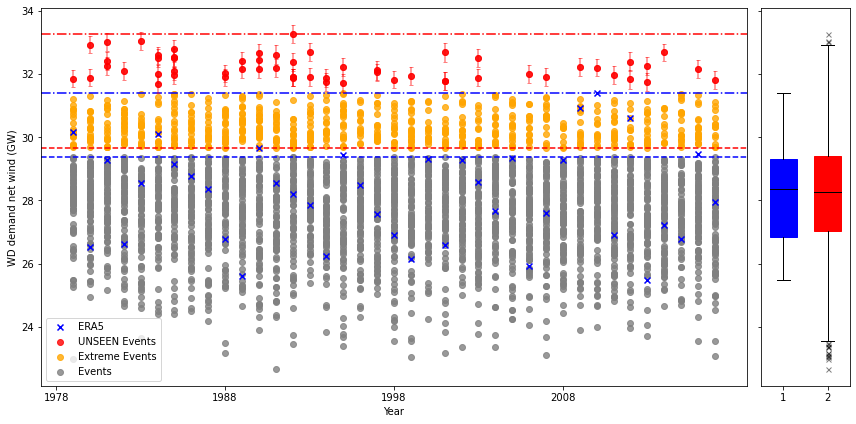

In [47]:
# Plot the events with error bars
# for the model data
funcs.plot_events_ts_errorbars(
    obs_df=df,
    model_df=model_df,
    obs_val_name="wd_demand_net_wind",
    model_val_name="wd_demand_net_wind",
    X1_col_model="sfcWind_bc",
    X2_col_model="tas_bc",
    Y_col="wd_demand_net_wind",
    ylabel="WD demand net wind (GW)",
    obs_time_name="time",
    model_time_name="init_year",
    figsize=(12, 6),
    low_bad=False,
)

Monthly mean average values are low relative to Hannah's clearheads values. Also CLEARHEADS wind speeds have been bias corrected to be higher (corrected to global wind atlas). Temperature bias lower than wind speed bias, as to be expected.

The plot above includes uncertainty in the regression model.

Another source of uncertainty which we can sample is the sample uncertainty, which results from a limited sample size (in this case ~40 years).

To quantify the uncertainty resulting from this, we can bootstrap the timeseries into 10-year chunks, which are selected randomly with replacement. Then take the 5%-95% range of these.

In [3]:
# Set up the directory where the clearhedas data are stored
data_dir = '/home/users/benhutch/CLEARHEADS_EU_Power_Data'

# List the clearheads data files
files = os.listdir(data_dir)

files

['EEZ_zones_wp_historical.nc',
 'NUTS_0_CDD_historical_pop_weighted.nc',
 'NUTS_0_HDD_historical_pop_weighted.nc',
 'NUTS_0_sp_historical.nc',
 'NUTS_0_sp_historical_loc_weighted.nc',
 'NUTS_0_speed100m_historical.nc',
 'NUTS_0_speed10m_historical.nc',
 'NUTS_0_speed10m_historical_pop_weighted.nc',
 'NUTS_0_ssrd_historical.nc',
 'NUTS_0_ssrd_historical_pop_weighted.nc',
 'NUTS_0_t2m_detrended_timeseries_historical.nc',
 'NUTS_0_t2m_detrended_timeseries_historical_pop_weighted.nc',
 'NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc',
 'NUTS_1_sp_historical.nc',
 'NUTS_1_speed100m_historical.nc',
 'NUTS_1_speed10m_historical.nc',
 'NUTS_1_ssrd_historical.nc',
 'NUTS_1_t2m_detrended_timeseries_historical.nc',
 'NUTS_1_wp_historical.nc',
 'NUTS_2_sp_historical.nc',
 'NUTS_2_speed100m_historical.nc',
 'NUTS_2_speed10m_historical.nc',
 'NUTS_2

In [4]:
# Create a list of the files to extract
files_to_extract = [
    "NUTS_0_sp_historical.nc",
    "NUTS_0_speed100m_historical.nc",
    "NUTS_0_speed10m_historical.nc",
    "NUTS_0_ssrd_historical.nc",
    "NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc",
    "NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc",
]

# Create a list with the names
names = [
    "solar_power",
    "100m_wind_speed",
    "10m_wind_speed",
    "solar_irradiance",
    "ofs_cfs",
    "ons_cfs",
]

# set up the country code to extract for
country_code = "UK" # France

In [5]:
# Set up an empty dataframe to store the data
df_full = pd.DataFrame()

# Loop over the files to extract
for file, name in tqdm(zip(files_to_extract, names)):
    # Load the data
    file_path = os.path.join(data_dir, file)

    # assert that the file exists
    assert os.path.exists(file_path), f"File {file_path} does not exist"

    # Load the data
    ds = xr.open_dataset(file_path)

    # # print ds.variables
    # print(ds.variables)

    # assert that NUTS_keys is in the variables
    assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

    # extract the nuts keys
    nuts_keys = ds["NUTS_keys"].values

    # turn the data into a dataframe
    df = ds.to_dataframe()

    # Pivot the dataframe
    df_pivot = df.reset_index().pivot(
        index="time_in_hours_from_first_jan_1950",
        columns="NUTS",
        values="timeseries_data",
    )

    # set the columns as the nuts keys
    df_pivot.columns = nuts_keys

    # Convert 'time_in_hours_from_first_jan_1950' column to datetime
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

    # constrain to the "UK" column
    df_pivot = df_pivot[country_code]

    # if this is the first iteration, set the index
    if df_full.empty:
        df_full = df_pivot.to_frame(name=name)
    else:
        df_full[name] = df_pivot

    # # print the head of the dataframe
    # print(df_full.head())

    # sys.exit()

0it [00:00, ?it/s]

6it [00:34,  5.73s/it]


In [6]:
df_full.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs
time_in_hours_from_first_jan_1950,,,,,,
1950-01-01 00:00:00,0.0,6.148996,3.976531,0.0,0.126081,0.150885
1950-01-01 01:00:00,0.0,6.156016,3.948778,0.0,0.132902,0.169805
1950-01-01 02:00:00,0.0,6.138777,3.957120,0.0,0.149275,0.195890
1950-01-01 03:00:00,0.0,6.390699,4.150732,0.0,0.163094,0.235261
1950-01-01 04:00:00,0.0,6.461800,4.243430,0.0,0.160107,0.261474


In [7]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 0

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot[country_code]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_no_detrend")
else:
    df_full["t2m_no_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: trend
4


In [8]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 2020

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot[country_code]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_2020_detrend")
else:
    df_full["t2m_2020_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: trend
3


In [9]:
df_full.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend
time_in_hours_from_first_jan_1950,,,,,,,,
1950-01-01 00:00:00,0.0,6.148996,3.976531,0.0,0.126081,0.150885,4.428690,5.895898
1950-01-01 01:00:00,0.0,6.156016,3.948778,0.0,0.132902,0.169805,4.583863,6.051068
1950-01-01 02:00:00,0.0,6.138777,3.957120,0.0,0.149275,0.195890,4.598047,6.065250
1950-01-01 03:00:00,0.0,6.390699,4.150732,0.0,0.163094,0.235261,4.460886,5.928087
1950-01-01 04:00:00,0.0,6.461800,4.243430,0.0,0.160107,0.261474,4.640312,6.107510


## Demand for other countries S2S4E ##

In [10]:
s2s4e_dir = "/home/users/benhutch/ERA5_energy_update/"

s2s4e_demand_fname = "ERA5_weather_dependent_demand_1979_2018.csv"

# Load the demand data
df_demand = pd.read_csv(os.path.join(s2s4e_dir, s2s4e_demand_fname))

In [11]:
df_demand.head()

,Unnamed: 0,Austria_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Belgium_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Bulgaria_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Croatia_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Czech_Republic_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Denmark_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Finland_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,France_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Germany_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,...,Norway_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Poland_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Portugal_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Romania_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Slovakia_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Slovenia_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Spain_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Sweden_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Switzerland_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,United_Kingdom_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat
0,1979-01-01,8.746085,13.285360,4.480123,2.085154,9.884955,4.783249,12.956948,84.793019,65.897470,...,25.146248,23.280473,6.086594,7.226054,3.787129,1.610934,30.384541,23.744467,7.982498,50.640896
1,1979-01-02,9.491813,12.498014,5.557895,2.349787,9.788056,4.681681,13.114426,87.320377,65.425365,...,23.944521,22.604713,6.196767,8.219921,4.005506,1.747526,30.824693,23.068526,8.423941,47.996807
2,1979-01-03,9.443403,12.691651,6.347009,2.380751,9.606212,4.688280,13.146203,85.420152,64.623033,...,24.518593,22.347208,6.064753,8.420241,3.977617,1.768301,30.861329,23.994230,8.289964,47.691554
3,1979-01-04,9.500878,12.419853,6.255989,2.310251,9.650421,4.763490,13.228586,78.860953,65.101535,...,24.663098,22.999755,6.315494,8.368188,3.973771,1.740730,30.850026,24.785046,8.244870,47.716700
4,1979-01-05,9.631089,12.872013,5.758050,2.309691,9.853166,4.737475,13.160649,80.113847,65.658008,...,23.663964,22.410664,6.581421,8.344409,4.035315,1.737661,31.378043,24.976397,8.212811,49.088719


In [12]:
# rename "Unnamed: 0" to "time"
df_demand = df_demand.rename(columns={"Unnamed: 0": "time"})

# set the time column as a datetime
df_demand["time"] = pd.to_datetime(df_demand["time"])

# set the time column as the index
df_demand = df_demand.set_index("time")

# reset all of the column names by splitting by the "_"
df_demand.columns = df_demand.columns.str.split("_").str[-11]

In [13]:
# print all of the column names
# rename kingdom to "United_Kingdom"
df_demand = df_demand.rename(columns={"Kingdom": "United_Kingdom"})

In [14]:
# subset to only the "United_Kingdom" column
df_demand = df_demand["United_Kingdom"]

In [15]:
# add a suffix of "_wd_demand" to the column name


In [16]:
df_demand.head()

time
1979-01-01    50.640896
1979-01-02    47.996807
1979-01-03    47.691554
1979-01-04    47.716700
1979-01-05    49.088719
Name: United_Kingdom, dtype: float64

In [17]:
# collapse df_full into daily means
df_full_daily = df_full.resample("D").mean()

In [18]:
# subset the df_full_daily to the same time period as the demand data
df_full_daily = df_full_daily.loc[df_demand.index.min() : df_demand.index.max()]

In [19]:
# merge the two dataframes
df_full_daily_fr = df_full_daily.merge(df_demand, left_index=True, right_index=True)

In [20]:
df_full_daily_fr.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom
time_in_hours_from_first_jan_1950,,,,,,,,,
1979-01-01,0.025562,6.931757,4.590929,67.520508,0.468063,0.242286,-4.111723,-3.252384,50.640896
1979-01-02,0.025708,6.937037,4.516651,69.008209,0.637265,0.265492,-0.858444,0.000838,47.996807
1979-01-03,0.025968,8.742168,5.599205,69.498589,0.434049,0.363244,-0.305985,0.553239,47.691554
1979-01-04,0.020316,8.498319,5.738192,54.448906,0.748136,0.270615,-0.771951,0.087217,47.716700
1979-01-05,0.026114,7.378688,4.994901,69.351974,0.420400,0.262179,-2.424707,-1.565598,49.088719


## Below is demand for UK from RMetS work ##

Now we have to use demand from S2S4E data for other countries (such as France).

Which gives us a shorter time period to look over.

In [21]:
# path to demand data
path="/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2024_daily_SP_WP_demand_wind.csv"

# impoet this df
df_demand = pd.read_csv(path)

In [22]:
df_demand.head()

,date,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,demand_net_wind,wd_demand_net_wind
0,1940-01-01,0.016125,0.344934,46.420023,47.228293,6.961509,-0.688529,10.217639,36.202385,37.010655
1,1940-01-02,0.013857,0.235733,47.953306,47.953306,5.675701,-1.658305,6.982887,40.970419,40.970419
2,1940-01-03,0.093672,0.386296,47.568234,47.568234,7.631405,-1.143233,11.442862,36.125371,36.125371
3,1940-01-04,0.094658,0.468219,46.787436,46.787436,8.341800,-0.098840,13.869574,32.917862,32.917862
4,1940-01-05,0.111828,0.168710,46.014368,46.914110,5.555250,-0.268279,4.997523,41.016845,41.916587


In [23]:
# subset to United_Kingdom_demand and United_Kingdom_wd_demand
df_demand_subset = df_demand[["date", "United_Kingdom_demand", "United_Kingdom_wd_demand"]]

In [24]:
df_demand_subset.head()

,date,United_Kingdom_demand,United_Kingdom_wd_demand
0,1940-01-01,46.420023,47.228293
1,1940-01-02,47.953306,47.953306
2,1940-01-03,47.568234,47.568234
3,1940-01-04,46.787436,46.787436
4,1940-01-05,46.014368,46.914110


In [25]:
# set date as datetime
df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])

# set date as index
df_demand_subset.set_index("date", inplace=True)

/tmp/ipykernel_12523/2338204410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])


In [26]:
# process df_full into daily data
df_full_daily = df_full.resample("D").mean()

In [27]:
#get the min and max date of df_full_daily
min_date = df_full_daily.index.min()
max_date = df_full_daily.index.max()

# subset the demand data to the same date range
df_demand_subset = df_demand_subset.loc[min_date:max_date]

# merge the two dataframes
df_full_daily = pd.concat([df_full_daily, df_demand_subset], axis=1)

In [28]:
df_full_daily.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
1950-01-01,0.017917,8.046321,5.313241,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834
1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818
1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278
1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399
1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605


In [29]:
#subset to ONDJFM mean
df_full_daily_ONDJFM = df_full_daily[
    (df_full_daily.index.month >= 10) | (df_full_daily.index.month <= 3)
]

In [30]:
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

# set up these but for France
installed_ofs_2023_fr = 0.842  # GW
installed_ons_2023_fr = 21.935  # GW

# calculate the wind power generation
df_full_daily_ONDJFM["wind_gen"] = (
    installed_ofs_2023 * df_full_daily_ONDJFM["ofs_cfs"]
    + installed_ons_2023 * df_full_daily_ONDJFM["ons_cfs"]
)

/tmp/ipykernel_12523/2300246560.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_daily_ONDJFM["wind_gen"] = (


In [31]:
# calculate the demand net wind
df_full_daily_ONDJFM["demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

# calculate the weather dependent demand
df_full_daily_ONDJFM["wd_demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_wd_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

/tmp/ipykernel_12523/2016973170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_daily_ONDJFM["demand_net_wind"] = (
/tmp/ipykernel_12523/2016973170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_daily_ONDJFM["wd_demand_net_wind"] = (


In [32]:
df_full_daily_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
1950-01-01,0.017917,8.046321,5.313241,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834,11.175803,27.232215,31.923031
1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818,15.022598,25.234949,26.043220
1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278,9.332292,31.820987,31.820987
1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399,12.886887,28.103513,28.103513
1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605,17.514048,23.976557,23.976557


In [37]:
# collapse the df into monthly means
df_full_monthly_ONDJFM = df_full_daily_ONDJFM.resample("ME").mean()

In [38]:
df_full_monthly_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
1950-01-31,0.023678,8.039311,5.391926,24.179867,0.530154,0.345105,4.596179,6.062498,42.052590,43.551624,12.953281,29.099309,30.598342
1950-02-28,0.052892,8.800127,5.949922,54.198185,0.665394,0.395162,4.133303,5.597930,42.210104,43.673353,15.693040,26.517064,27.980312
1950-03-31,0.093137,7.571613,5.151695,96.710487,0.469686,0.307299,6.514069,7.977003,40.513451,41.864119,11.498996,29.014456,30.365124
1950-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# drop the nans from the dataframe
df_full_monthly_ONDJFM = df_full_monthly_ONDJFM.dropna()

In [ ]:
# shift the time back by 3 months and take the mean
df_full_daily_ONDJFM = df_full_daily_ONDJFM.shift(-3, freq="M")

# take the annual mean
df_full_daily_ONDJFM = df_full_daily_ONDJFM.resample("Y").mean()

# drop the first and last year
df_full_daily_ONDJFM = df_full_daily_ONDJFM.iloc[1:-1]

In [30]:
# do the same but for the france df
df_full_daily_fr_ONDJFM = df_full_daily_fr[
    (df_full_daily_fr.index.month >= 10) | (df_full_daily_fr.index.month <= 3)
]

# shift the time back by 3 months and take the mean
df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.shift(-3, freq="M")

# take the annual mean
df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.resample("Y").mean()

# drop the first and last year
df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.iloc[1:-1]

/tmp/ipykernel_46740/2555997553.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.shift(-3, freq="M")
/tmp/ipykernel_46740/2555997553.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.resample("Y").mean()


In [31]:
# set the index to the year
df_full_daily_ONDJFM.index = df_full_daily_ONDJFM.index.year

In [32]:
df_full_daily_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
2015,0.045989,8.546028,5.803546,65.247696,0.604229,0.381584,7.051015,7.134888,39.997589,41.452842
2016,0.047428,7.717142,5.185671,80.963707,0.510453,0.312648,6.824999,6.887897,40.287380,41.750628
2017,0.046698,8.437108,5.717490,90.249214,0.604882,0.372400,5.869819,5.911770,40.966321,42.429570
2018,0.046976,8.259077,5.535166,90.075439,0.563557,0.363519,7.054070,7.075075,40.049438,41.512686
2019,0.047315,8.718687,5.897901,100.707596,0.614796,0.402140,6.523098,6.523128,40.475453,41.930705


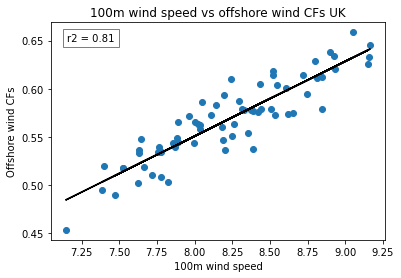

In [33]:
# plot a scttaer between 100m wind speed and ofs_cfs
plt.scatter(df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"])

plt.xlabel("100m wind speed")
plt.ylabel("Offshore wind CFs")

# include a line of best fit
m, b = np.polyfit(
    df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"], 1
)

plt.plot(df_full_daily_ONDJFM["100m_wind_speed"], m * df_full_daily_ONDJFM["100m_wind_speed"] + b, color="k")

# calculate the r2 value
r2 = np.corrcoef(df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"])[0, 1] ** 2

# text in the top left with r2
plt.text(
    0.05,
    0.95,
    f"r2 = {r2:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# set the title
plt.title("100m wind speed vs offshore wind CFs UK")

plt.show()

In [41]:
def plot_scatter_with_fit(df, x_col, y_col, title, xlabel, ylabel):
    # plot a scatter between x_col and y_col
    plt.scatter(df[x_col], df[y_col])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # include a line of best fit
    m, b = np.polyfit(df[x_col], df[y_col], 1)

    plt.plot(df[x_col], m * df[x_col] + b, color="k")

    # calculate the r2 value
    r2 = np.corrcoef(df[x_col], df[y_col])[0, 1] ** 2

    # text in the top left with r2
    plt.text(
        0.05,
        0.95,
        f"r2 = {r2:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # set the title
    plt.title(title)

    plt.show()

In [37]:
df_full_daily_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
2020-12-27,0.023757,8.940444,5.979577,24.189680,0.615395,0.446767,3.649454,3.628710,39.387627,44.078443,15.722401,23.665226,28.356042
2020-12-28,0.018903,5.019287,3.424141,19.100378,0.200217,0.086603,1.774313,1.753511,45.024194,45.832464,4.241845,40.782349,41.590619
2020-12-29,0.020817,7.124440,4.698165,21.119453,0.311446,0.210541,2.592501,2.571643,45.236083,45.236083,7.725595,37.510488,37.510488
2020-12-30,0.023254,5.399757,3.439529,23.473879,0.334843,0.130754,1.594081,1.573165,46.053290,46.053290,6.884724,39.168566,39.168566
2020-12-31,0.023311,6.773319,4.563665,23.496550,0.205502,0.190531,1.811103,1.790130,46.040684,46.040684,5.864829,40.175855,40.175855


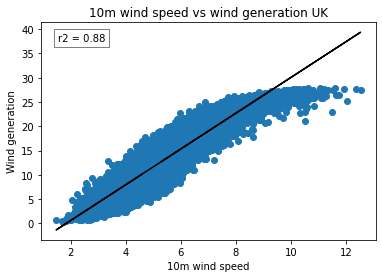

In [35]:
# plot the daily relationship between 10m wind speed and wind generation
# for the UK
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation UK",
    xlabel="10m wind speed",
    ylabel="Wind generation",
)

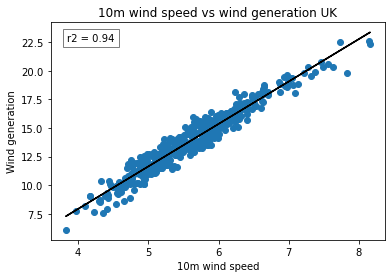

In [42]:
# plot the monthly ONDJFM relationship between 10m wind speed and wind generation
# monthly means of O, N, D, J, F, M for the UK
plot_scatter_with_fit(
    df=df_full_monthly_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation UK",
    xlabel="10m wind speed",
    ylabel="Wind generation",
)

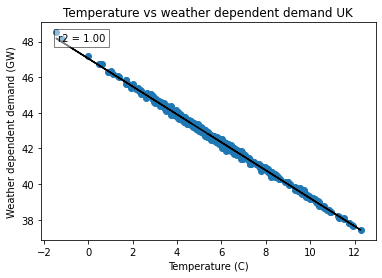

In [43]:
# plot the monthly ONDJFM relationship between temperature and wd demand
# monthly means of O, N, D, J, F, M for the UK
plot_scatter_with_fit(
    df=df_full_monthly_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="United_Kingdom_wd_demand",
    title="Temperature vs weather dependent demand UK",
    xlabel="Temperature (C)",
    ylabel="Weather dependent demand (GW)",
)

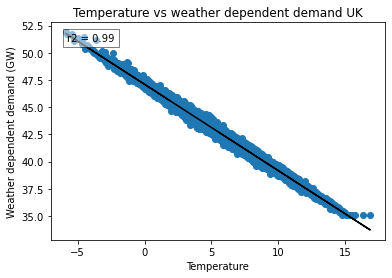

In [43]:
# plot the daily relationship between temperature and weathe dependent demand UK
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="United_Kingdom_wd_demand",
    title="Temperature vs weather dependent demand UK",
    xlabel="Temperature",
    ylabel="Weather dependent demand (GW)",
)

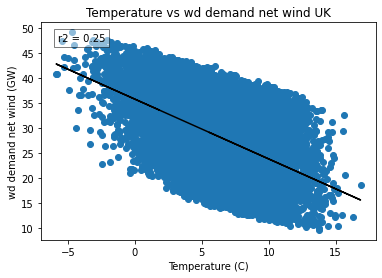

In [41]:
# daily relationship between temperature and wd demand net wind UK
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="wd_demand_net_wind",
    title="Temperature vs wd demand net wind UK",
    xlabel="Temperature (C)",
    ylabel="wd demand net wind (GW)",
)

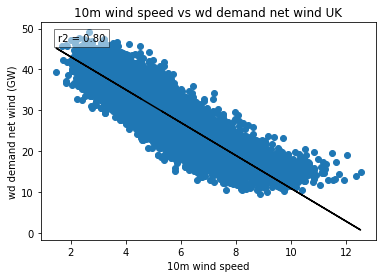

In [44]:
# daily relationship betqeen 10m wind speed and wd demand net wind UK
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wd_demand_net_wind",
    title="10m wind speed vs wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="wd demand net wind (GW)",
)

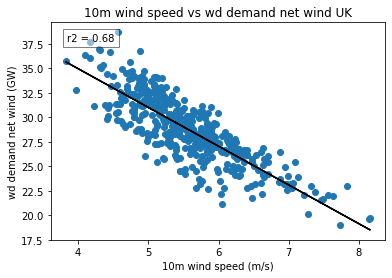

In [44]:
# plot the monthly relationship between 10m wind speed and wd demand net wind UK
plot_scatter_with_fit(
    df=df_full_monthly_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wd_demand_net_wind",
    title="10m wind speed vs wd demand net wind UK",
    xlabel="10m wind speed (m/s)",
    ylabel="wd demand net wind (GW)",
)

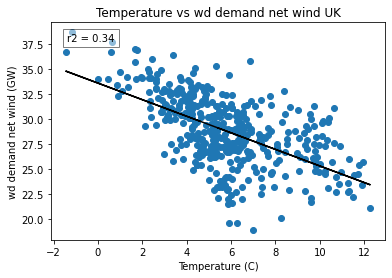

In [45]:
# plot the monthly relationship between temperature and wd demand net wind UK
plot_scatter_with_fit(
    df=df_full_monthly_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="wd_demand_net_wind",
    title="Temperature vs wd demand net wind UK",
    xlabel="Temperature (C)",
    ylabel="wd demand net wind (GW)",
)

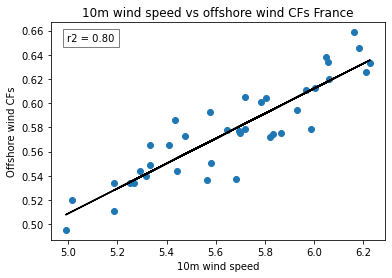

In [35]:
# plot scatter with fit for france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="ofs_cfs",
    title="10m wind speed vs offshore wind CFs France",
    xlabel="10m wind speed",
    ylabel="Offshore wind CFs",
)

In [36]:
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="ofs_cfs",
#     title="10m wind speed vs offshore wind CFs UK",
#     xlabel="10m wind speed",
#     ylabel="Offshore wind CFs",
# )

In [37]:
# # 100m and onshore wind speed
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="100m_wind_speed",
#     y_col="ons_cfs",
#     title="100m wind speed vs onshore wind CFs UK",
#     xlabel="100m wind speed",
#     ylabel="Onshore wind CFs",
# )

In [38]:
# # 10m and onshore wind speed
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="ons_cfs",
#     title="10m wind speed vs onshore wind CFs UK",
#     xlabel="10m wind speed",
#     ylabel="Onshore wind CFs",
# )

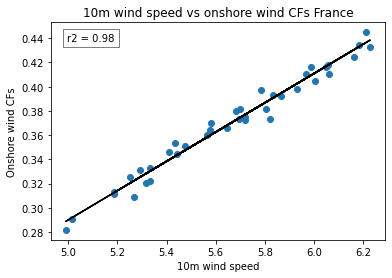

In [39]:
# 10m wind speed and onshore cfs france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="ons_cfs",
    title="10m wind speed vs onshore wind CFs France",
    xlabel="10m wind speed",
    ylabel="Onshore wind CFs",
)

In [40]:
# # solar irradiance and solar power cfs
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="solar_irradiance",
#     y_col="solar_power",
#     title="Solar irradiance vs solar power UK",
#     xlabel="Solar irradiance (W/m^2)",
#     ylabel="Solar power CFs",
# )

In [41]:
# # temperature and demand
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="United_Kingdom_demand",
#     title="Temperature vs demand UK",
#     xlabel="Temperature (K)",
#     ylabel="Demand (GW)",
# )

In [42]:
# # temperature and weather dependent demand
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="United_Kingdom_wd_demand",
#     title="Temperature vs weather dependent demand UK",
#     xlabel="Temperature (K)",
#     ylabel="Weather dependent demand (GW)",
# )

In [43]:
# # temperature vs demand france
# plot_scatter_with_fit(
#     df=df_full_daily_fr_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="France",
#     title="Temperature vs wd demand France",
#     xlabel="Temperature (K)",
#     ylabel="Wd demand (GW)",
# )

In [44]:
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

# set up these but for France
installed_ofs_2023_fr = 0.842  # GW
installed_ons_2023_fr = 21.935  # GW

# calculate the wind power generation
df_full_daily_ONDJFM["wind_gen"] = (
    installed_ofs_2023 * df_full_daily_ONDJFM["ofs_cfs"]
    + installed_ons_2023 * df_full_daily_ONDJFM["ons_cfs"]
)

In [46]:
df

time_in_hours_from_first_jan_1950  trend_levels NUTS_keys  \
time   NUTS                                                              
0      0                                   0.0        2020.0        AT   
       1                                   0.0        2020.0        AL   
       2                                   0.0        2020.0        BY   
       3                                   0.0        2020.0        BE   
       4                                   0.0        2020.0        BA   
...                                        ...           ...       ...   
622391 33                             622391.0        2020.0        SE   
       34                             622391.0        2020.0        CH   
       35                             622391.0        2020.0        TR   
       36                             622391.0        2020.0        UA   
       37                             622391.0        2020.0        UK   

             detrended_data  
time   NUTS                  
0      0          -6.020338  
       1           4.064733  
       2         -11.611506  
       3           0.192663  
       4          -0.899436  
...                     ...  
622391 33         -1.393751  
       34         -4.744075  
       35          4.747882  
       36          4.292526  
       37          1.940524  

[23650896 rows x 4 columns]

In [47]:
# calculate the wind power generation for France
df_full_daily_fr_ONDJFM["wind_gen"] = (
    installed_ofs_2023_fr * df_full_daily_fr_ONDJFM["ofs_cfs"]
    + installed_ons_2023_fr * df_full_daily_fr_ONDJFM["ons_cfs"]
)

In [48]:
df_full_daily_fr_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom,wind_gen
time_in_hours_from_first_jan_1950,,,,,,,,,,
1979-12-31,0.044770,7.775867,5.266900,96.103203,0.534070,0.309185,5.503710,6.342160,42.641409,7.231666
1980-12-31,0.045061,9.048603,6.161487,68.925476,0.658672,0.424508,5.600564,6.418039,42.512209,9.866188
1981-12-31,0.048453,8.326015,5.646829,66.818642,0.577480,0.366008,4.758259,5.554789,43.261635,8.514615
1982-12-31,0.043366,9.156328,6.229273,77.202827,0.633381,0.432983,5.910626,6.686210,42.346853,10.030782
1983-12-31,0.045663,8.536577,5.820777,69.140457,0.572323,0.373300,5.711908,6.466516,42.493461,8.670238


In [49]:
# calculate the demand net wind
df_full_daily_ONDJFM["demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

# calculate the weather dependent demand
df_full_daily_ONDJFM["wd_demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_wd_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

In [50]:
# # calculate the demand net wind for France
# df_full_daily_fr_ONDJFM["wd_demand_net_wind"] = (
#     df_full_daily_fr_ONDJFM["France"] - df_full_daily_fr_ONDJFM["wind_gen"]
# )

In [51]:
# # plot 10m wind speed vs wind generation
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="wind_gen",
#     title="10m wind speed vs wind generation UK",
#     xlabel="10m wind speed",
#     ylabel="Wind generation (GW)",
# )

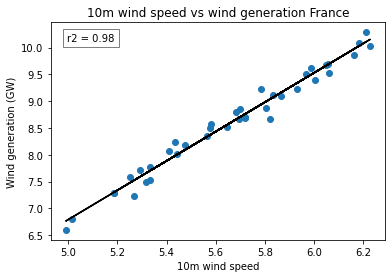

In [52]:
# 10m wind speed vs wind generation France
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation France",
    xlabel="10m wind speed",
    ylabel="Wind generation (GW)",
)

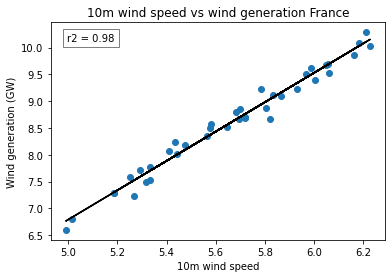

In [53]:
# plot the scatter of 10m wind speed and wind generation france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation France",
    xlabel="10m wind speed",
    ylabel="Wind generation (GW)",
)

In [54]:
# # wind generation vs demand net wind france
# plot_scatter_with_fit(
#     df=df_full_daily_fr_ONDJFM,
#     x_col="wind_gen",
#     y_col="wd_demand_net_wind",
#     title="Wind generation vs wd demand net wind France",
#     xlabel="Wind generation (GW)",
#     ylabel="wd demand net wind (GW)",
# )

In [55]:
# # scatter of 100m wind speed vs demand net wind
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="100m_wind_speed",
#     y_col="wd_demand_net_wind",
#     title="100m wind speed vs Wd demand net wind UK",
#     xlabel="100m wind speed",
#     ylabel="wd demand net wind (GW)",
# )

In [56]:
# # 10m wind speed vs demand net wind france
# plot_scatter_with_fit(
#     df=df_full_daily_fr_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="wd_demand_net_wind",
#     title="10m wind speed vs Wd demand net wind France",
#     xlabel="10m wind speed",
#     ylabel="wd demand net wind (GW)",
# )

In [57]:
# # 10m wind speed vs wd demand net wind
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="wd_demand_net_wind",
#     title="10m wind speed vs Wd demand net wind UK",
#     xlabel="10m wind speed",
#     ylabel="wd demand net wind (GW)",
# )

In [58]:
# # temperature vs wd demand net wind
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="wd_demand_net_wind",
#     title="Temperature vs Wd demand net wind UK",
#     xlabel="Temperature (K)",
#     ylabel="wd demand net wind (GW)",
# )

In [59]:
# # temperature vs wd demand net wind france
# plot_scatter_with_fit(
#     df=df_full_daily_fr_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="wd_demand_net_wind",
#     title="Temperature vs Wd demand net wind France",
#     xlabel="Temperature (K)",
#     ylabel="wd demand net wind (GW)",
# )

In [46]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_3d_scatter(df, x_col, y_col, z_col, title, xlabel, ylabel, zlabel):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df[x_col], df[y_col], df[z_col])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Fit a multiple linear regression model
    X = df[[x_col, y_col]]
    y = df[z_col]
    model = LinearRegression().fit(X, y)

    # Calculate the R-squared value
    r2 = model.score(X, y)

    # Print the R-squared value
    print(f'R-squared: {r2:.2f}')

    # Plot the regression plane
    x_range = np.linspace(X[x_col].min(), X[x_col].max(), num=10)
    y_range = np.linspace(X[y_col].min(), X[y_col].max(), num=10)
    x_range, y_range = np.meshgrid(x_range, y_range)
    z_range = model.predict(np.array([x_range.flatten(), y_range.flatten()]).T).reshape(x_range.shape)
    ax.plot_surface(x_range, y_range, z_range, alpha=0.5)

    plt.show()

R-squared: 0.90


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


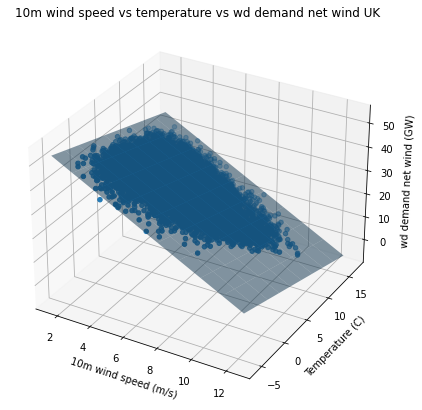

In [47]:
# plot the 3d scatter of 10m wind speed, temperature and wd demand net wind
# for the daily data for the UK
plot_3d_scatter(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed vs temperature vs wd demand net wind UK",
    xlabel="10m wind speed (m/s)",
    ylabel="Temperature (C)",
    zlabel="wd demand net wind (GW)",
)

R-squared: 0.96


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


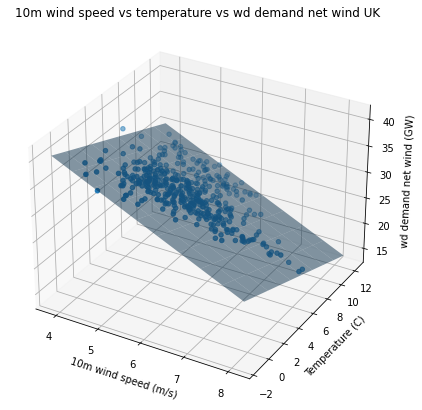

In [47]:
# plot the 3D scatter betqeen 10m wind speed, temperature and wd demand net wind
# for the monthly data for the UK
plot_3d_scatter(
    df=df_full_monthly_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed vs temperature vs wd demand net wind UK",
    xlabel="10m wind speed (m/s)",
    ylabel="Temperature (C)",
    zlabel="wd demand net wind (GW)",
)

In [61]:
# # 3d scatter of 10m wind speed, temperature and wd demand net wind for France
# plot_3d_scatter(
#     df=df_full_daily_fr_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="t2m_no_detrend",
#     z_col="wd_demand_net_wind",
#     title="10m wind speed, temperature and wd demand net wind France",
#     xlabel="10m wind speed",
#     ylabel="Temperature (K)",
#     zlabel="wd demand net wind (GW)",
# )

In [62]:
# # print the head of the france dataframe
# df_full_daily_fr_ONDJFM.tail()

R-squared: 0.97


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


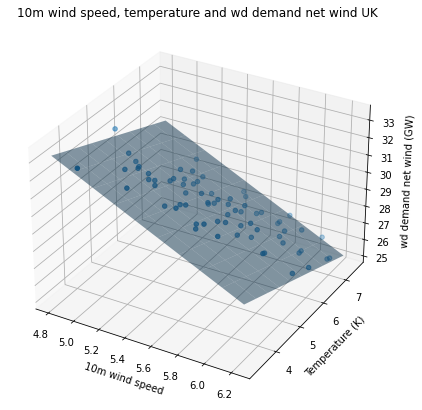

In [63]:
# 3d scatter of 100m wind speed, temperature and wd demand net wind
plot_3d_scatter(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed, temperature and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

Now we want to test the strength of this MLR fit by providing the model with 10m wind speeds and 2m temperatures over the UK for a given season and getting it to predict the weather-dependent demand net wind.

We can then compare the results of this to our demand net wind variable and see how close they are.

In [64]:
# Fit a multiple linear regression model
# Fit a multiple linear regression model
X = df_full_daily_ONDJFM[["10m_wind_speed", "t2m_no_detrend"]]
y = df_full_daily_ONDJFM["wd_demand_net_wind"]
model = LinearRegression().fit(X, y)

# Calculate the R-squared value
r2 = model.score(X, y)

# Print the R-squared value
print(f'R-squared: {r2:.2f}')

# Predict the z values (i.e., wd_demand_net_wind) for the corresponding x and y values in each row
z_predicted = model.predict(X)

# Print the shape of the z_predicted
print(np.shape(z_predicted))

R-squared: 0.97
(70,)


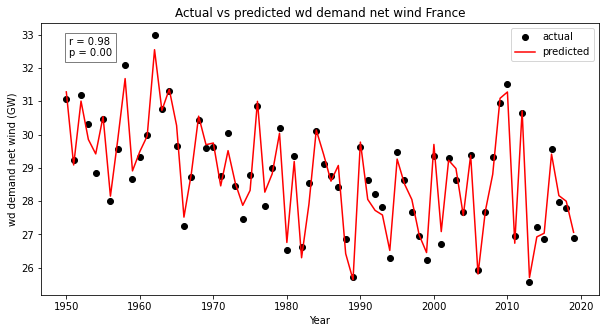

In [65]:
from scipy.stats import pearsonr

# set up a figure
fig = plt.figure(figsize=(10, 5))

# plot the actual wd demand net wind values
plt.scatter(df_full_daily_ONDJFM.index, df_full_daily_ONDJFM["wd_demand_net_wind"], label="actual", color="k")

# plot the predicted wd demand net wind values
plt.plot(df_full_daily_ONDJFM.index, z_predicted, label="predicted", color="r")

# set the title
plt.title("Actual vs predicted wd demand net wind France")

# calculate the correlation between the actual and predicted values
r, p = pearsonr(df_full_daily_ONDJFM["wd_demand_net_wind"], z_predicted)

# text in the top left with r2
plt.text(
    0.05,
    0.95,
    f"r = {r:.2f}\np = {p:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# set the x label
plt.xlabel("Year")

# set the y label
plt.ylabel("wd demand net wind (GW)")

# show the legend
plt.legend()

Now import the temperature and wind speed data from DePreSys. It fails the fidelity tests for this test period (1960-1965) but that's kind of expected as we only have 5 observations and 50 model combinations.

We assume, therefore, that it has passed the fidelity tests, and now we are trying to translate the wind speeds and temperatures into demand net wind via our observed relationship.

In [66]:
# Set up the path to the data
csv_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"
sfcwind_fname = "HadGEM3-GC31-MM_sfcWind_United Kingdom_ONDJFM_1960_2018_dcppA-hindcast_Amon.csv"
t2m_fname = "HadGEM3-GC31-MM_tas_United Kingdom_ONDJFM_1960_2018_dcppA-hindcast_Amon.csv"

# Load the data
df_sfcwind = pd.read_csv(os.path.join(csv_dir, sfcwind_fname))

# Load the data
df_t2m = pd.read_csv(os.path.join(csv_dir, t2m_fname))

In [67]:
df_sfcwind.tail()

,init_year,member,lead,data
73745,2018,9,121,4.228160
73746,2018,9,122,4.457373
73747,2018,9,123,4.761541
73748,2018,9,124,5.108000
73749,2018,9,125,5.987636


In [68]:
df_t2m.tail()

,init_year,member,lead,data
73745,2018,9,121,279.425814
73746,2018,9,122,275.692171
73747,2018,9,123,275.730993
73748,2018,9,124,278.457006
73749,2018,9,125,277.875223


In [69]:
# rename the data column for df_sfcwind
df_sfcwind.rename(columns={"data": "sfcWind"}, inplace=True)

# rename the data column for df_t2m
df_t2m.rename(columns={"data": "tas"}, inplace=True)

In [70]:
# merge the dataframes
df = pd.merge(df_sfcwind, df_t2m, on=['init_year', 'member', 'lead'])

In [71]:
df.tail()

,init_year,member,lead,sfcWind,tas
73745,2018,9,121,4.228160,279.425814
73746,2018,9,122,4.457373,275.692171
73747,2018,9,123,4.761541,275.730993
73748,2018,9,124,5.108000,278.457006
73749,2018,9,125,5.987636,277.875223


In [72]:
# convert tas from K to C
df["tas"] = df["tas"] - 273.15

In [73]:
# create a new cf to calculate the means over the ONDJFM
df_new = pd.DataFrame()

# loop over the unique init years and members in df
for init_year in df['init_year'].unique():
    for member in df['member'].unique():
        # extract the model data
        model_data = df[(df['init_year'] == init_year) & (df['member'] == member)]

        # subset to lead values [12, 13, 14, 15, 16, 17] and take the mean
        # first complete ONDJFM season
        model_data = model_data[model_data['lead'].isin([12, 13, 14, 15, 16, 17])]

        mean_tas = model_data['tas'].mean()
        mean_sfcWind = model_data['sfcWind'].mean()

        # create a dataframe this
        model_data_this = pd.DataFrame(
            {
                'init_year': [init_year],
                'member': [member],
                'tas': [mean_tas],
                'sfcWind': [mean_sfcWind]
            }
        )

        df_new = pd.concat([df_new, model_data_this])


In [74]:
df_new.tail()

,init_year,member,tas,sfcWind
0,2018,5,6.091286,4.798880
0,2018,6,6.364391,5.126203
0,2018,7,6.412649,5.249331
0,2018,8,7.330928,5.289885
0,2018,9,6.933735,5.198534


Now load in the processed observations.

In [75]:
ERA5_tas_fname = "ERA5_obs_tas_United Kingdom_ONDJFM_1960_2018.csv"
ERA5_sfcWind_fname = "ERA5_obs_sfcWind_United Kingdom_ONDJFM_1960_2018.csv"

# Load the data
df_ERA5_tas = pd.read_csv(os.path.join(csv_dir, ERA5_tas_fname))
df_ERA5_sfcWind = pd.read_csv(os.path.join(csv_dir, ERA5_sfcWind_fname))

In [76]:
df_ERA5_tas

,time,obs
0,1960-10-01,282.668868
1,1960-11-01,279.559365
2,1960-12-01,276.477476
3,1961-01-01,275.904981
4,1961-02-01,279.151625
...,...,...
697,2018-11-01,281.000623
698,2018-12-01,279.623851
699,2019-01-01,277.192738
700,2019-02-01,279.633808


In [77]:
# reset the name of the obs column
df_ERA5_tas.rename(columns={"obs": "tas"}, inplace=True)
df_ERA5_sfcWind.rename(columns={"obs": "sfcWind"}, inplace=True)

In [78]:
# merge the dataframes
df_ERA5 = pd.merge(df_ERA5_tas, df_ERA5_sfcWind, on=['time'])

In [79]:
df_ERA5.head()

,time,tas,sfcWind
0,1960-10-01,282.668868,4.131944
1,1960-11-01,279.559365,4.934281
2,1960-12-01,276.477476,4.428460
3,1961-01-01,275.904981,4.940405
4,1961-02-01,279.151625,5.247938


In [80]:
# Make sure time is datetime
df_ERA5['time'] = pd.to_datetime(df_ERA5['time'])

# set the index to time
df_ERA5.set_index('time', inplace=True)

In [81]:
# subset to months (10, 11, 12, 1, 2, 3)
df_ERA5_ONDJFM = df_ERA5[(df_ERA5.index.month >= 10) | (df_ERA5.index.month <= 3)]

In [82]:
df_ERA5_ONDJFM.head()

,tas,sfcWind
time,,
1960-10-01,282.668868,4.131944
1960-11-01,279.559365,4.934281
1960-12-01,276.477476,4.428460
1961-01-01,275.904981,4.940405
1961-02-01,279.151625,5.247938


In [83]:
# shift back by 3 months and resample to yearly means
df_ERA5_ONDJFM = df_ERA5_ONDJFM.shift(-3, freq='M').resample('Y').mean()

/tmp/ipykernel_46740/1358686657.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ERA5_ONDJFM = df_ERA5_ONDJFM.shift(-3, freq='M').resample('Y').mean()
/tmp/ipykernel_46740/1358686657.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_ERA5_ONDJFM = df_ERA5_ONDJFM.shift(-3, freq='M').resample('Y').mean()


In [84]:
df_ERA5_ONDJFM.head()

,tas,sfcWind
time,,
1960-12-31,279.019333,4.769488
1961-12-31,277.546575,4.943203
1962-12-31,275.847431,4.461803
1963-12-31,277.939379,4.545248
1964-12-31,277.520771,4.559657


In [85]:
df_new.head()

,init_year,member,tas,sfcWind
0,1960,10,4.687112,4.600986
0,1960,1,5.311010,4.820743
0,1960,2,3.118230,4.761391
0,1960,3,5.348982,4.939705
0,1960,4,4.684333,4.969560


In [86]:
# Convert ERA5 tas from K to C
df_ERA5_ONDJFM['tas'] = df_ERA5_ONDJFM['tas'] - 273.15

In [87]:
# calculate the mean bias for wind speed and temperature
sfcWind_bias = df_new['sfcWind'].mean() - df_ERA5_ONDJFM['sfcWind'].mean()

tas_bias = df_new['tas'].mean() - df_ERA5_ONDJFM['tas'].mean()

# print the biases
print(f"Mean bias sfcWind: {sfcWind_bias:.2f}")

print(f"Mean bias tas: {tas_bias:.2f}")

Mean bias sfcWind: 0.11
Mean bias tas: -0.63


Those look more sensible

Now we want to fit the model to the correct ERA5 tas and sfcWind data. Which has been regridded to the same grid as DePreSys and then masked for the UK at the same resolution.

In [88]:
# df_full_daily_ONDJFM_subset.tail()

In [89]:
# subset df_full_daily_ONDJFM to the same years as df_new
df_full_daily_ONDJFM_subset = df_full_daily_ONDJFM.loc[df_new['init_year'].unique()]

In [90]:
# create a new dataframe with the same index as df_full_daily_ONDJFM_subset
# but with sfcWind and tas from df_ERA5_ONDJFM
# and wd_demand_net_wind from df_full_daily_ONDJFM_subset
df_new_full = pd.DataFrame(index=df_full_daily_ONDJFM_subset.index)

# add the columns
df_new_full['sfcWind'] = df_ERA5_ONDJFM['sfcWind'].values
df_new_full['tas'] = df_ERA5_ONDJFM['tas'].values
df_new_full['wd_demand_net_wind'] = df_full_daily_ONDJFM_subset['wd_demand_net_wind'].values

In [91]:
df_new_full.tail()

,sfcWind,tas,wd_demand_net_wind
2014,5.245268,6.415540,27.230571
2015,5.276976,7.046968,26.864198
2016,4.572490,6.627535,29.570563
2017,5.092172,5.715136,27.967829
2018,4.958459,6.968584,27.792762


In [92]:
# add the temperature and wind speed data from hannah stuff
df_new_full['tas_ch'] = df_full_daily_ONDJFM_subset['t2m_no_detrend'].values
df_new_full['sfcWind_ch'] = df_full_daily_ONDJFM_subset['10m_wind_speed'].values

In [93]:
df_new_full.head()

,sfcWind,tas,wd_demand_net_wind,tas_ch,sfcWind_ch
1960,4.769488,5.869333,29.328790,6.046000,5.314873
1961,4.943203,4.396575,29.978915,4.647103,5.455883
1962,4.461803,2.697431,32.978647,3.256981,5.002560
1963,4.545248,4.789379,30.775384,5.084062,5.156683
1964,4.559657,4.370771,31.321400,4.668887,5.060365


In [94]:
# add wind generation and wd demand to the df_new_full
df_new_full['wind_gen'] = df_full_daily_ONDJFM_subset['wind_gen'].values
df_new_full['United_Kingdom_wd_demand'] = df_full_daily_ONDJFM_subset['United_Kingdom_wd_demand'].values

In [95]:
df_new_full.head()

,sfcWind,tas,wd_demand_net_wind,tas_ch,sfcWind_ch,wind_gen,United_Kingdom_wd_demand
1960,4.769488,5.869333,29.328790,6.046000,5.314873,13.009050,42.337840
1961,4.943203,4.396575,29.978915,4.647103,5.455883,13.457975,43.436890
1962,4.461803,2.697431,32.978647,3.256981,5.002560,11.647347,44.625994
1963,4.545248,4.789379,30.775384,5.084062,5.156683,12.353624,43.129009
1964,4.559657,4.370771,31.321400,4.668887,5.060365,12.111368,43.432768


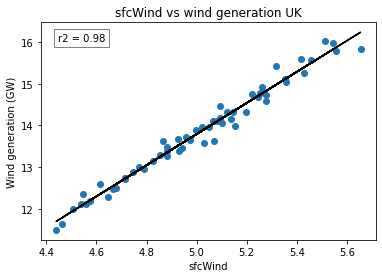

In [96]:
# plot the scatter between the sfcWind and the wind generation
plot_scatter_with_fit(
    df=df_new_full,
    x_col="sfcWind",
    y_col="wind_gen",
    title="sfcWind vs wind generation UK",
    xlabel="sfcWind",
    ylabel="Wind generation (GW)",
)

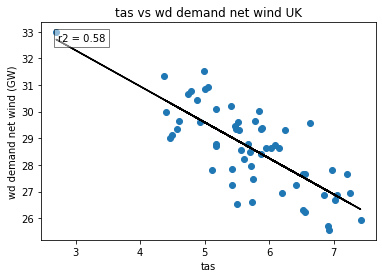

In [97]:
# plot the scatter between the temperature and the UK wd demand
plot_scatter_with_fit(
    df=df_new_full,
    x_col="tas",
    y_col="wd_demand_net_wind",
    title="tas vs wd demand net wind UK",
    xlabel="tas",
    ylabel="wd demand net wind (GW)",
)

Very weak (no?) relationships between the monthly means and the variables. Quite surprising really?

Is this masking to the correct location?

R-squared: 0.97


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


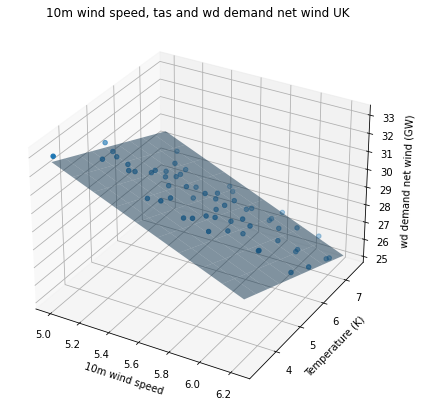

In [98]:
# fit a multiple linear regression model
plot_3d_scatter(
    df=df_new_full,
    x_col="sfcWind_ch",
    y_col="tas_ch",
    z_col="wd_demand_net_wind",
    title="10m wind speed, tas and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

R-squared: 0.99


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


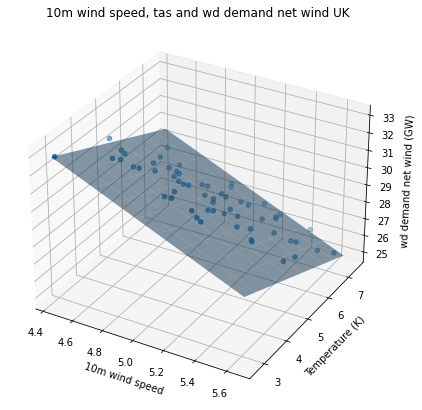

In [99]:
# fit a multiple linear regression model
plot_3d_scatter(
    df=df_new_full,
    x_col="sfcWind",
    y_col="tas",
    z_col="wd_demand_net_wind",
    title="10m wind speed, tas and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

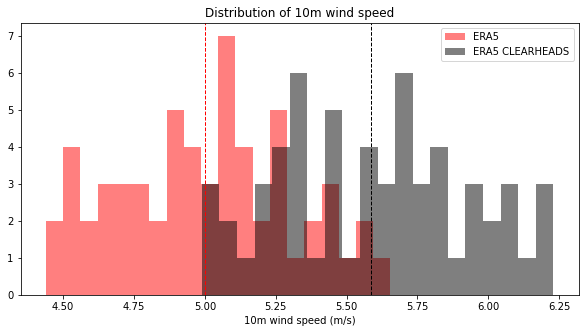

In [100]:
# plot the distibution of the sfcwind and sfcwind_ch
# set up the figure
plt.figure(figsize=(10, 5))

plt.hist(df_new_full['sfcWind'], bins=20, alpha=0.5, label='ERA5', color='r')
plt.hist(df_new_full['sfcWind_ch'], bins=20, alpha=0.5, label='ERA5 CLEARHEADS', color='k')

plt.xlabel('10m wind speed (m/s)')

plt.legend()

# include the mean as a vertical line
plt.axvline(df_new_full['sfcWind'].mean(), color='r', linestyle='dashed', linewidth=1)

plt.axvline(df_new_full['sfcWind_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

# set a title
plt.title('Distribution of 10m wind speed')

plt.show()

ERA5 regrid own method 10m wind speeds much higher than CLEARHEADS. Appears to have more spread as well.

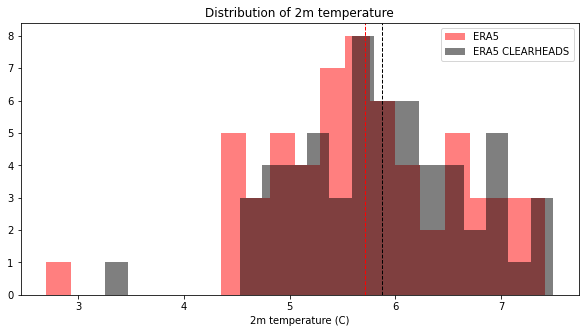

In [101]:
# plot the distibution of the tas and tas_ch
# set up the figure
plt.figure(figsize=(10, 5))

plt.hist(df_new_full['tas'], bins=20, alpha=0.5, label='ERA5', color='r')
plt.hist(df_new_full['tas_ch'], bins=20, alpha=0.5, label='ERA5 CLEARHEADS', color='k')

plt.xlabel('2m temperature (C)')

plt.legend()

# include the mean as a vertical line
plt.axvline(df_new_full['tas'].mean(), color='r', linestyle='dashed', linewidth=1)

plt.axvline(df_new_full['tas_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

# set a title
plt.title('Distribution of 2m temperature')

plt.show()


Text(0.5, 1.0, 'Time series of 10m wind speed: ERA5 vs ERA5 CLEARHEADS')

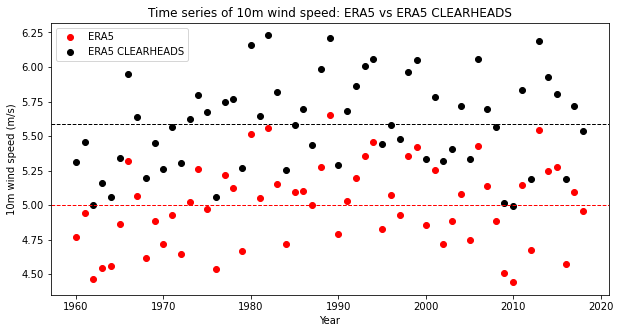

In [102]:
# plot the time series of the wind speed
plt.figure(figsize=(10, 5))

plt.scatter(df_new_full.index, df_new_full['sfcWind'], label='ERA5', color='r')
plt.scatter(df_new_full.index, df_new_full['sfcWind_ch'], label='ERA5 CLEARHEADS', color='k')

plt.xlabel('Year')
plt.ylabel('10m wind speed (m/s)')

# include the mean as a horizontal line
plt.axhline(df_new_full['sfcWind'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axhline(df_new_full['sfcWind_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.legend()

plt.title('Time series of 10m wind speed: ERA5 vs ERA5 CLEARHEADS')

Text(0.5, 1.0, 'Time series of 2m temperature: ERA5 vs ERA5 CLEARHEADS')

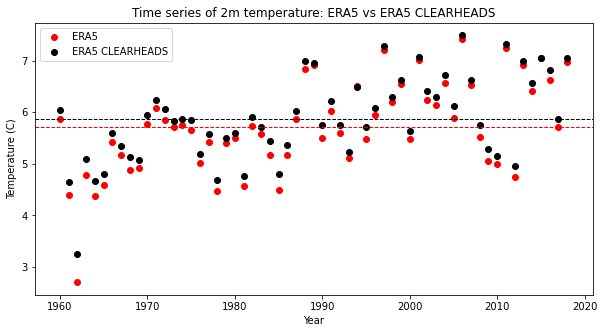

In [103]:
# same but for temperature
plt.figure(figsize=(10, 5))

plt.scatter(df_new_full.index, df_new_full['tas'], label='ERA5', color='r')
plt.scatter(df_new_full.index, df_new_full['tas_ch'], label='ERA5 CLEARHEADS', color='k')

plt.xlabel('Year')
plt.ylabel('Temperature (C)')

# include the mean as a horizontal line
plt.axhline(df_new_full['tas'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axhline(df_new_full['tas_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.legend()

plt.title('Time series of 2m temperature: ERA5 vs ERA5 CLEARHEADS')

Slight mean bias for when CLEARHEADS is compared to own method. The most important thing is that the relationship between temperature + wind speed and wd demand net wind is strong. We should now be able to use this MLR with the model (once mean biases are corrected)

In [104]:
df.tail()

,init_year,member,lead,sfcWind,tas
73745,2018,9,121,4.228160,6.275814
73746,2018,9,122,4.457373,2.542171
73747,2018,9,123,4.761541,2.580993
73748,2018,9,124,5.108000,5.307006
73749,2018,9,125,5.987636,4.725223


In [105]:
model_df = df

In [106]:
# create a new list of leads
leads = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# extract the first NDJFM for fidelity testing
# create a new cf to calculate the means over the ONDJFM
df_new = pd.DataFrame()

# loop over the unique init years and members in model_df
for init_year in model_df['init_year'].unique():
    for member in model_df['member'].unique():
        for l in leads:
            # extract the model data
            model_data = model_df[(model_df['init_year'] == init_year) & (model_df['member'] == member)]

            # subset to lead values [(12*l) ,(12*l) + 1, (12*l) + 2, (12*l) + 3, (12*l) + 4, (12*l) + 5]
            # first complete NDJFM season
            model_data = model_data[model_data['lead'].isin([(12*l) ,(12*l) + 1, (12*l) + 2, (12*l) + 3, (12*l) + 4, (12*l) + 5])]

            mean_tas = model_data['tas'].mean()
            mean_sfcWind = model_data['sfcWind'].mean()

            # create a dataframe this
            model_data_this = pd.DataFrame(
                {
                    'init_year': [init_year],
                    'member': [member],
                    'lead': [l],
                    'tas': [mean_tas],
                    'sfcWind': [mean_sfcWind]
                }
            )

            df_new = pd.concat([df_new, model_data_this])

In [107]:
df_new.head()

,init_year,member,lead,tas,sfcWind
0,1960,10,1,4.687112,4.600986
0,1960,10,2,6.201248,5.685612
0,1960,10,3,4.325177,6.139293
0,1960,10,4,3.933457,4.772283
0,1960,10,5,3.427872,4.503686


In [108]:
df_ERA5_ONDJFM.head()

,tas,sfcWind
time,,
1960-12-31,5.869333,4.769488
1961-12-31,4.396575,4.943203
1962-12-31,2.697431,4.461803
1963-12-31,4.789379,4.545248
1964-12-31,4.370771,4.559657


In [109]:
# Quantify an remove the mean bias
sfcWind_bias = df_new['sfcWind'].mean() - df_ERA5_ONDJFM['sfcWind'].mean()

tas_bias = df_new['tas'].mean() - df_ERA5_ONDJFM['tas'].mean()

# print the biases
print(f"Mean bias sfcWind: {sfcWind_bias:.2f}")
print(f"Mean bias tas: {tas_bias:.2f}")

Mean bias sfcWind: 0.17
Mean bias tas: -0.67


In [129]:
# add a new column in the model df for the bias corrected data
df_new['sfcWind_bias_corrected'] = df_new['sfcWind'] - sfcWind_bias
df_new['tas_bias_corrected'] = df_new['tas'] - tas_bias

In [130]:
# check that the bias correction has worked
print(f"Mean bias corrected sfcWind: {df_new['sfcWind_bias_corrected'].mean():.2f}")
print(f"Mean bias corrected tas: {df_new['tas_bias_corrected'].mean():.2f}")
print(f"Mean ERA5 sfcWind: {df_ERA5_ONDJFM['sfcWind'].mean():.2f}")
print(f"Mean ERA5 tas: {df_ERA5_ONDJFM['tas'].mean():.2f}")
print(f"Mean df full sfcWind: {df_new_full['sfcWind'].mean():.2f}")
print(f"Mean df full tas: {df_new_full['tas'].mean():.2f}")

Mean bias corrected sfcWind: 5.00
Mean bias corrected tas: 5.71
Mean ERA5 sfcWind: 5.00
Mean ERA5 tas: 5.71
Mean df full sfcWind: 5.00
Mean df full tas: 5.71


In this case, the data for the UK only passes both fidelity tests for ONDJFM when all extended winters are included (e.g. 10 sample winters per forecast member per init).

In [112]:
df_full_daily_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
1950,0.047499,7.646948,5.173771,83.073708,0.548256,0.310508,4.196776,5.643096,42.319801,43.783050,12.706080,29.613721,31.076969
1951,0.047739,8.181735,5.514787,90.237427,0.560338,0.349737,5.592817,7.018162,41.233875,42.693545,13.467535,27.766340,29.226010
1952,0.050879,7.622873,5.111364,100.821899,0.502315,0.315162,4.916879,6.321249,41.823209,43.286458,12.097345,29.725864,31.189112
1953,0.046912,7.780230,5.257252,95.875870,0.508089,0.317957,5.822387,7.205811,41.090066,42.553315,12.224112,28.865954,30.329203
1954,0.050365,8.245254,5.576068,91.555550,0.610629,0.363492,4.797606,6.160084,41.805261,43.268509,14.414106,27.391154,28.854403


In [113]:
df_new_full.tail()

,sfcWind,tas,wd_demand_net_wind,tas_ch,sfcWind_ch,wind_gen,United_Kingdom_wd_demand
2014,5.245268,6.415540,27.230571,6.558036,5.929480,14.693515,41.924085
2015,5.276976,7.046968,26.864198,7.051015,5.803546,14.588644,41.452842
2016,4.572490,6.627535,29.570563,6.824999,5.185671,12.180065,41.750628
2017,5.092172,5.715136,27.967829,5.869819,5.717490,14.461740,42.429570
2018,4.958459,6.968584,27.792762,7.054070,5.535166,13.719925,41.512686


In [114]:
model_df.head()

,init_year,member,lead,sfcWind,tas,sfcWind_bias_corrected,tas_bias_corrected
0,1960,10,1,5.336514,6.784728,5.164946,7.456308
1,1960,10,2,4.371142,3.991181,4.199574,4.662761
2,1960,10,3,5.651277,3.960962,5.479709,4.632541
3,1960,10,4,7.513435,4.707627,7.341867,5.379206
4,1960,10,5,6.595717,4.548799,6.424148,5.220378


In [115]:
# Set up the model which predicts the clearheads wd demand net wind
# given our observed sfcWind and tas
X = df_new_full[['sfcWind', 'tas']]
y = df_new_full['wd_demand_net_wind']
model = LinearRegression().fit(X, y)

# Calculate the R-squared value
r2 = model.score(X, y)

# Print the R-squared value
print(f'R-squared: {r2:.2f}')

# Predict the z values (i.e., wd_demand_net_wind) for the corresponding x and y values in each row
z_predicted = model.predict(X)

# Print the shape of the z_predicted
print(np.shape(z_predicted))

R-squared: 0.99
(59,)


Now that we have the model fitted, we want to apply this to the model data.

In [131]:
# add a new column to the model df
X_model = df_new[['sfcWind_bias_corrected', 'tas_bias_corrected']]

# predict the wd demand net wind
df_new['wd_demand_net_wind_predicted'] = model.predict(X_model)

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- sfcWind_bias_corrected
- tas_bias_corrected
Feature names seen at fit time, yet now missing:
- sfcWind
- tas

  warnings.warn(message, FutureWarning)


In [132]:
df_new.head()

,init_year,member,lead,tas,sfcWind,sfcWind_bias_corrected,tas_bias_corrected,wd_demand_net_wind_predicted
0,1960,10,1,4.687112,4.600986,4.429418,5.358691,31.050708
0,1960,10,2,6.201248,5.685612,5.514044,6.872827,25.875261
0,1960,10,3,4.325177,6.139293,5.967725,4.996756,25.491989
0,1960,10,4,3.933457,4.772283,4.600715,4.605036,30.938159
0,1960,10,5,3.427872,4.503686,4.332118,4.099451,32.312543


In [118]:
df_new_full.head()

,sfcWind,tas,wd_demand_net_wind,tas_ch,sfcWind_ch,wind_gen,United_Kingdom_wd_demand
1960,4.769488,5.869333,29.328790,6.046000,5.314873,13.009050,42.337840
1961,4.943203,4.396575,29.978915,4.647103,5.455883,13.457975,43.436890
1962,4.461803,2.697431,32.978647,3.256981,5.002560,11.647347,44.625994
1963,4.545248,4.789379,30.775384,5.084062,5.156683,12.353624,43.129009
1964,4.559657,4.370771,31.321400,4.668887,5.060365,12.111368,43.432768


In [119]:
# name the index in df_new_full
df_new_full.index.name = 'year'

# reset the index in df_new_full
df_new_full.reset_index(inplace=True)

In [133]:
# check that the bias correction has worked
print(f"Mean bias corrected sfcWind: {df_new['sfcWind_bias_corrected'].mean():.2f}")
print(f"Mean bias corrected tas: {df_new['tas_bias_corrected'].mean():.2f}")
print(f"Mean ERA5 sfcWind: {df_ERA5_ONDJFM['sfcWind'].mean():.2f}")
print(f"Mean ERA5 tas: {df_ERA5_ONDJFM['tas'].mean():.2f}")
print(f"Mean df full sfcWind: {df_new_full['sfcWind'].mean():.2f}")
print(f"Mean df full tas: {df_new_full['tas'].mean():.2f}")

Mean bias corrected sfcWind: 5.00
Mean bias corrected tas: 5.71
Mean ERA5 sfcWind: 5.00
Mean ERA5 tas: 5.71
Mean df full sfcWind: 5.00
Mean df full tas: 5.71


In [136]:
df_new.shape

(5900, 8)

Now we can plot this for comparison. Just need to find the plotting scripts.

In [134]:
# reload the functions
import importlib
importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

The model mean is 28.639412753945685
The obs mean is 28.639412753945685
The years min is 1960 and the years max is 2018


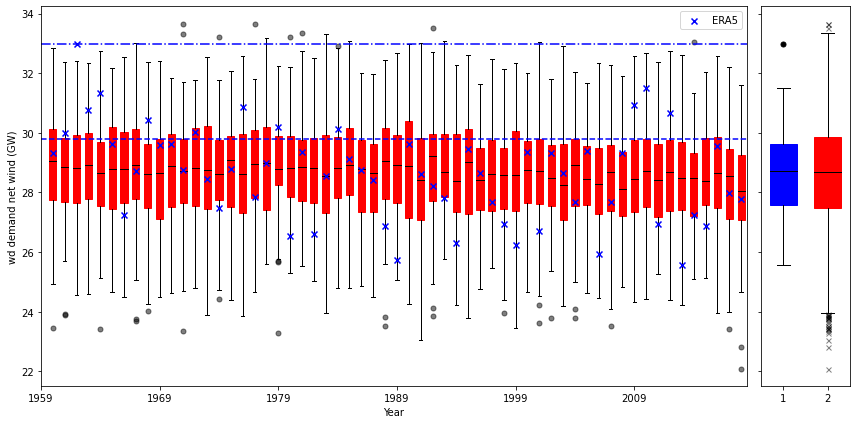

In [135]:
funcs.plot_events_ts_bp(
    obs_df=df_new_full,
    model_df=df_new,
    obs_val_name='wd_demand_net_wind',
    model_val_name='wd_demand_net_wind_predicted',
    ylabel='wd demand net wind (GW)',   
    obs_time_name='year',
    model_time_name='init_year',
    figsize=(12, 6),
    low_bad=False,
)

The model mean is 5.001601202312177
The obs mean is 5.001601202312177
The years min is 1960 and the years max is 2018


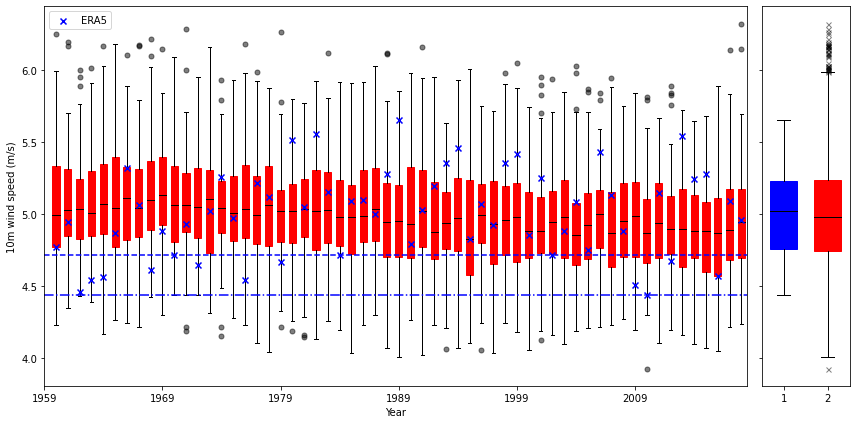

In [137]:
funcs.plot_events_ts_bp(
    obs_df=df_new_full,
    model_df=df_new,
    obs_val_name='sfcWind',
    model_val_name='sfcWind_bias_corrected',
    ylabel='10m wind speed (m/s)',
    obs_time_name='year',
    model_time_name='init_year',
    delta_shift_bias=False,
    figsize=(12, 6),
    low_bad=True,
)

The model mean is 5.708182887993788
The obs mean is 5.708182887993788
The years min is 1960 and the years max is 2018


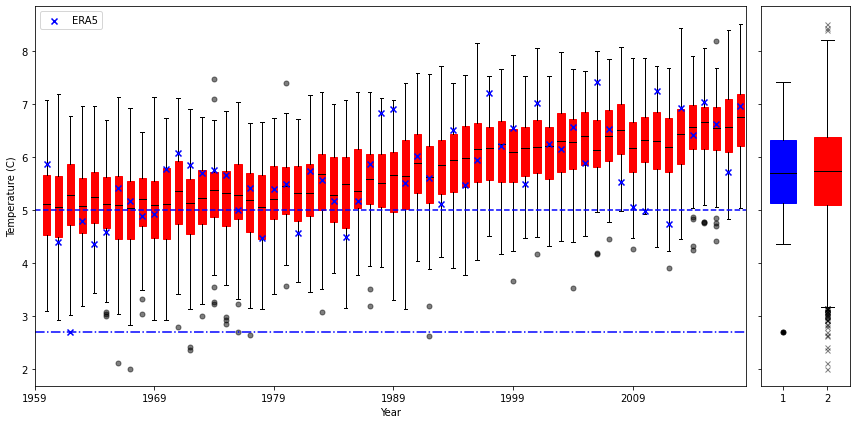

In [138]:
funcs.plot_events_ts_bp(
    obs_df=df_new_full,
    model_df=df_new,
    obs_val_name='tas',
    model_val_name='tas_bias_corrected',
    ylabel='Temperature (C)',
    obs_time_name='year',
    model_time_name='init_year',
    delta_shift_bias=False,
    figsize=(12, 6),
    low_bad=True,
)

In [56]:
# set up the predictors
X_model = df_new[["sfcWind", "tas"]]

# predict the wd demand net wind
df_new["wd_demand_net_wind_pred"] = model.predict(X_model)

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- sfcWind
- tas
Feature names seen at fit time, yet now missing:
- 10m_wind_speed
- t2m_no_detrend

  warnings.warn(message, FutureWarning)


In [58]:
df_new.tail()

,init_year,member,tas,sfcWind,wd_demand_net_wind_pred
0,1965,5,2.112552,10.577661,13.329649
0,1965,6,1.540891,10.461658,14.143121
0,1965,7,1.063251,10.056174,15.930461
0,1965,8,1.695330,10.802726,12.811498
0,1965,9,1.414509,10.719741,13.304441


In [59]:
# print the min and max of the predicted wd demand net wind
print(df_new["wd_demand_net_wind_pred"].min())
print(df_new["wd_demand_net_wind_pred"].max())

12.321390576936885
18.29980755598997


Seems far too low. Perhaps a result of the mean biases in the model. The observed wind speeds are biased low (i.e. ERA5 winds are too still) so demand net wind will be higher as a result. While the observed temperatures are biased high, which will mean reduced winter demand? Winds are likely more of a dominant influence in the model though. Will have to do this with the full data.